# MNIST example using scivae

Here we just show a simple example of how the data we can encode & predict from the dataset.



In [1]:
import os
import shutil
import tempfile
import unittest
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scivae import Optimiser, VAE, Validate
from sciviso import Scatterplot



# Set the location of the mnist data
data_dir = '../tests/data/mnist/'
image_size = 28
# The more images/data you have the better it will be
num_images = 40000

# Set up the data format (you don't normally need to do this (i.e. a normal np array works best))
test_f = open(f'{data_dir}train-images-idx3-ubyte', 'rb')
test_f.read(16)
buf = test_f.read(image_size * image_size * num_images)
test_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
test_data = test_data.reshape(num_images, image_size * image_size)

# Read in teh training labels
f = open(f'{data_dir}train-labels-idx1-ubyte', 'rb')
f.read(8)
test_labels = []
for i in range(0, len(test_data)):
    buf = f.read(1)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    test_labels.append(labels[0])




In [3]:
# Create a configuration for the dataset
config = {'loss': {'loss_type': 'mse', 'distance_metric': 'bmmd', 'mmd_weight': 1.0}, 
          'encoding': {'layers': [{'num_nodes': 1028, 'activation_fn': 'selu'},
                                  {'num_nodes': 128, 'activation_fn': 'relu'}]}, 
          'decoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'relu'}, 
                                  {'num_nodes': 1028, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 2}, 'optimiser': {'params': {}, 'name': 'adam'},
         "sample_method": "bimodal"}

# Run the VAE 
vae = VAE(test_data, test_data, test_labels, config, 'vae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
vae.encode('default', epochs=10, batch_size=1000)
# get the encoded data
encoding = vae.get_encoded_data()

None
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1028)         806980      default_input[0][0]              
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          131712      dense_5[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            258         dense_6[0][0]                    
_______________________________________________________________________________________

34/34 [==============================] - 3s 86ms/step - loss: 95.9364 - val_loss: 90.7632
Epoch 2/10
34/34 [==============================] - 3s 80ms/step - loss: 90.4531 - val_loss: 90.7645
Epoch 3/10
34/34 [==============================] - 3s 79ms/step - loss: 90.4490 - val_loss: 90.7512
Epoch 4/10
34/34 [==============================] - 3s 75ms/step - loss: 90.4478 - val_loss: 90.7508
Epoch 5/10
34/34 [==============================] - 3s 80ms/step - loss: 90.4457 - val_loss: 90.7508
Epoch 6/10
34/34 [==============================] - 3s 81ms/step - loss: 90.4434 - val_loss: 90.7549
Epoch 7/10
34/34 [==============================] - 3s 82ms/step - loss: 90.4454 - val_loss: 90.7509
Epoch 8/10
34/34 [==============================] - 3s 85ms/step - loss: 90.4458 - val_loss: 90.7568
Epoch 9/10
34/34 [==============================] - 3s 86ms/step - loss: 90.4455 - val_loss: 90.7509
Epoch 10/10
34/34 [==============================] - 3s 81ms/step - loss: 90.4453 - val_loss: 90.7511


In [12]:
encoding

array([[-0.9094452 , -0.98635   ],
       [-0.6808693 , -2.0386589 ],
       [-1.7447963 , -3.3660207 ],
       ...,
       [-2.3481946 , -1.4742064 ],
       [ 0.09526569, -1.7773153 ],
       [ 0.43968186,  1.5771111 ]], dtype=float32)

## Visualise the reconstruction


Have a look at how good the reconstruction is from the latent space.

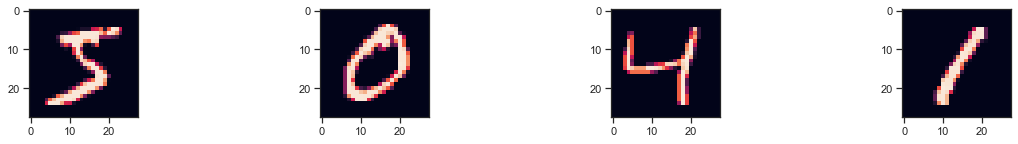

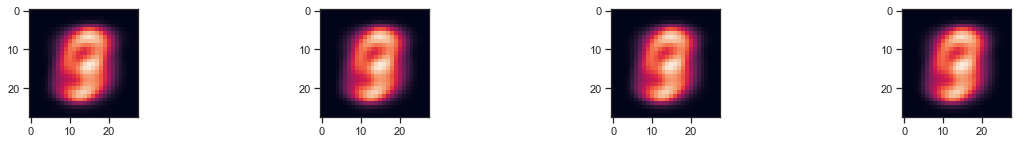

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Show some of the images (4)
n = 4

# Show the true data
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))

plt.show()
# Ensure we're encoding and decoding the same dataset
scaler = MinMaxScaler(copy=True)
test_data_scaled = scaler.fit_transform(test_data)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)

encoding = vae.encode_new_data(test_data_scaled)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
d = vae.decoder.predict(encoding)
plt.figure(figsize=(20, 2))
n = 4
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[i,:].reshape(28, 28))

plt.show()

## Visualise the latent space

Here we can have a look at the latent space by simply plotting the latent space & looking at how our labels separate.

In [5]:
encoding = vae.encoded_data[0]
encoding[:, 1]

array([ 12.786636, -19.35727 , -41.172726, ...,  13.315105, -13.295311,
        18.25193 ], dtype=float32)

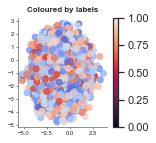

In [14]:
# Plot the latent space - have a look at the first two latent nodes
vis_df = pd.DataFrame()

vis_df['latent_0'] = encoding[:, 0]
vis_df['latent_1'] = encoding[:, 1]


# Zip the colours to make the labels into numeric values
lut = dict(zip(set(test_labels), sns.color_palette("coolwarm", len(set(test_labels)))))
row_colors2 = pd.DataFrame(test_labels)[0].map(lut)
vis_df['label'] = row_colors2
scatter = Scatterplot(vis_df, 'latent_0', 'latent_1',  
                      colour=row_colors2, title='Coloured by labels')
scatter.plot()
plt.show()

In [32]:
# Create a configuration for the dataset
config_mmcd = {'loss': {'loss_type': 'mse', 'distance_metric': 'bmmd', 'mmd_weight': 4}, 
          'encoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'selu'},
                                  {'num_nodes': 64, 'activation_fn': 'relu'}]}, 
          'decoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'relu'}, 
                                  {'num_nodes': 128, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 2}, 'optimiser': {'params': {}, 'name': 'adam'}}


# Run the VAE 
vae_mmcd = VAE(test_data, test_data, test_labels, config_mmcd, 'vae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
vae_mmcd.encode('default', epochs=100, batch_size=1000)
# get the encoded data
encoding_mmcd = vae_mmcd.get_encoded_data()


None
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          100480      default_input[0][0]              
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 64)           8256        dense_10[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            130         dense_11[0][0]                   
_______________________________________________________________________________________

34/34 [==============================] - 2s 51ms/step - loss: 62.9595 - val_loss: 46.6107
Epoch 2/100
34/34 [==============================] - 1s 42ms/step - loss: 44.4891 - val_loss: 43.1991
Epoch 3/100
34/34 [==============================] - 1s 42ms/step - loss: 42.3932 - val_loss: 41.6775
Epoch 4/100
34/34 [==============================] - 1s 41ms/step - loss: 41.1074 - val_loss: 40.6530
Epoch 5/100
34/34 [==============================] - 1s 39ms/step - loss: 40.1879 - val_loss: 39.7466
Epoch 6/100
34/34 [==============================] - 1s 40ms/step - loss: 39.4081 - val_loss: 39.0809
Epoch 7/100
34/34 [==============================] - 1s 40ms/step - loss: 38.7275 - val_loss: 38.3670
Epoch 8/100
34/34 [==============================] - 1s 42ms/step - loss: 38.1554 - val_loss: 37.8073
Epoch 9/100
34/34 [==============================] - 1s 42ms/step - loss: 37.7246 - val_loss: 37.4444
Epoch 10/100
34/34 [==============================] - 2s 45ms/step - loss: 37.3633 - val_loss:

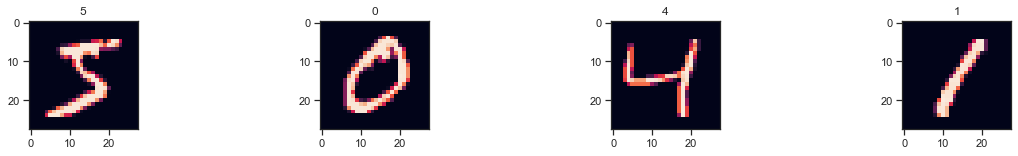

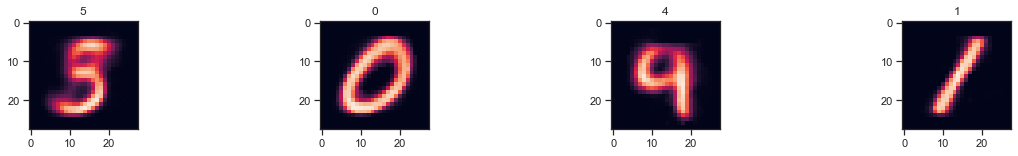

In [42]:
from sklearn.preprocessing import MinMaxScaler
# Show some of the images (4)
n = 4

# Show the true data
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))
    plt.title(test_labels[i])

plt.show()
scaler = MinMaxScaler(copy=True)
test_data_scaled = scaler.fit_transform(test_data)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
encoding_mmcd = vae_mmcd.encode_new_data(test_data_scaled)

d = vae_mmcd.decoder.predict(encoding_mmcd)
plt.figure(figsize=(20, 2))
n = 4
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[i,:].reshape(28, 28))
    plt.title(test_labels[i])
plt.show()

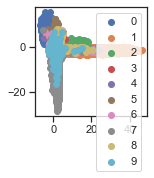

In [34]:
# Plot the latent space - have a look at the first two latent nodes
fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    ax.scatter(encoding_mmcd[:, 0][idxs], encoding_mmcd[:, 1][idxs], label=f'{i}')
ax.legend()


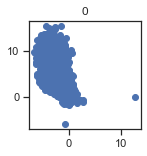

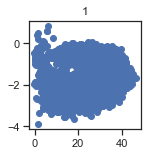

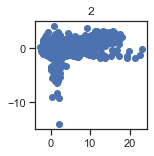

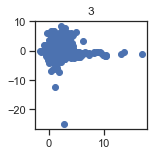

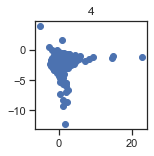

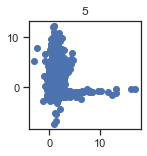

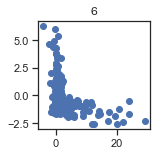

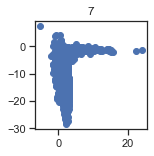

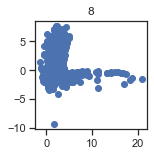

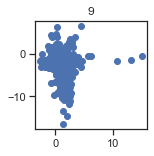

In [35]:
fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    plt.scatter(encoding_mmcd[:, 0][idxs], encoding_mmcd[:, 1][idxs], label=f'{i}')
    plt.title(f'{i}')
    plt.show()
ax.legend()



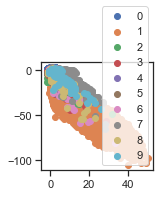

In [41]:
fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    ax.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
ax.legend()


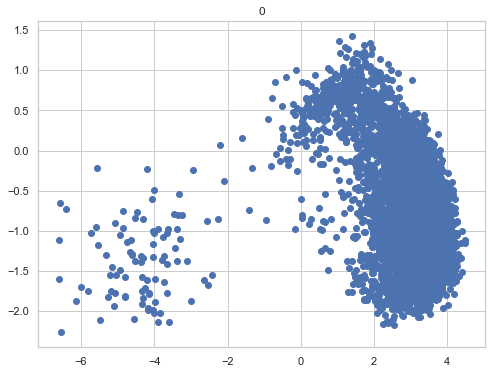

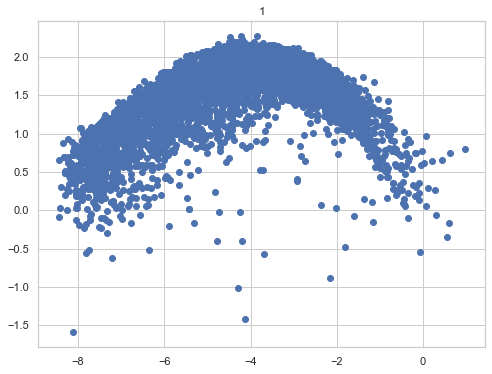

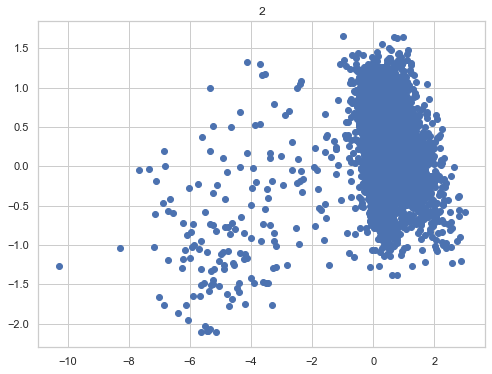

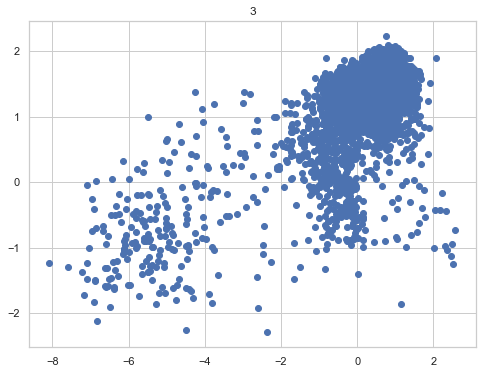

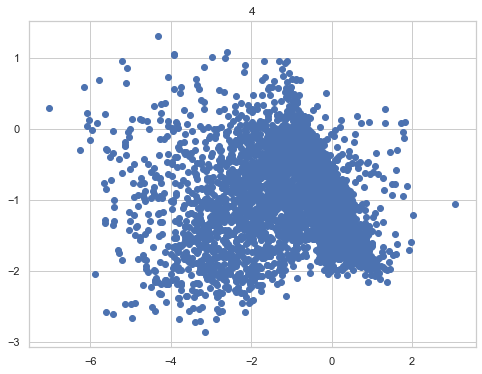

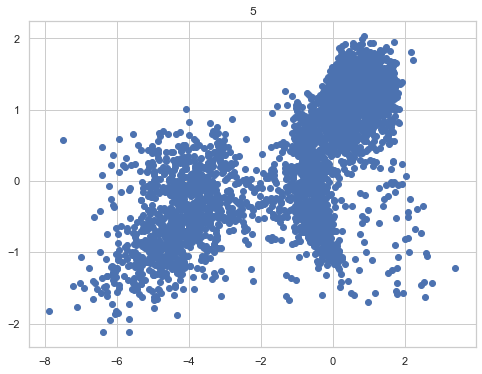

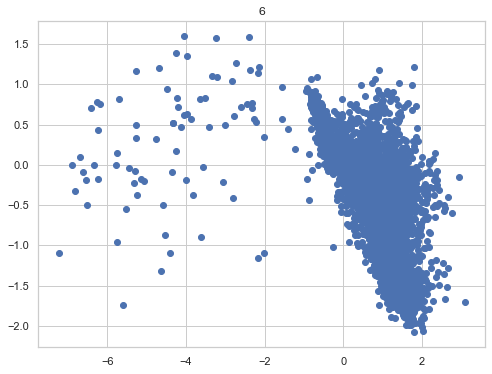

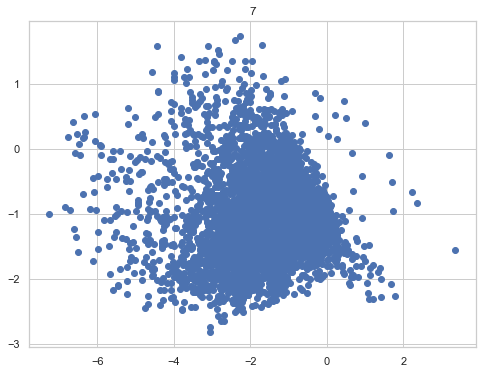

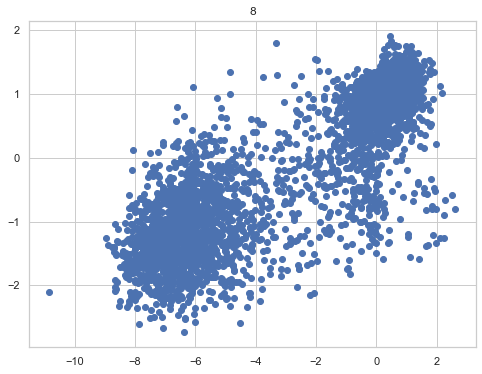

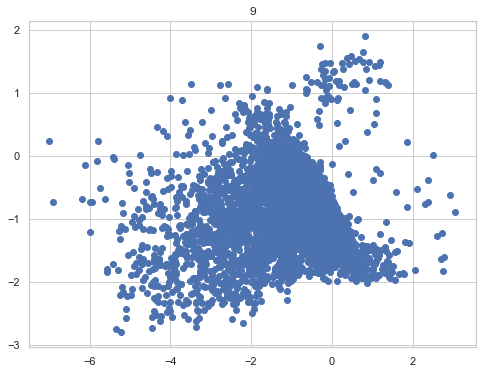

In [68]:
fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    plt.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
    plt.title(f'{i}')
    plt.show()
ax.legend()



In [47]:
# Create a configuration for the dataset
config = {'loss': {'loss_type': 'mse', 'distance_metric': 'bmmd', 'mmd_weight': 5.0}, 
          'encoding': {'layers': [{'num_nodes': 500, 'activation_fn': 'selu'},
                                  {'num_nodes': 128, 'activation_fn': 'relu'}]}, 
          'decoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'relu'}, 
                                  {'num_nodes': 500, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 64}, 'optimiser': {'params': {}, 'name': 'adam'}, 
         "sample_method": "bimodal"}



# Run the VAE 
vae = VAE(test_data, test_data, test_labels, config, 'vae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
vae.encode('default', epochs=100, batch_size=1000)
# get the encoded data
encoding = vae.get_encoded_data()

None
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 500)          392500      default_input[0][0]              
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 128)          64128       dense_25[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 64)           8256        dense_26[0][0]                   
_______________________________________________________________________________________

34/34 [==============================] - 23s 674ms/step - loss: 85.4101 - val_loss: 59.0677
Epoch 2/100
34/34 [==============================] - 22s 650ms/step - loss: 51.2177 - val_loss: 48.4296
Epoch 3/100
34/34 [==============================] - 22s 661ms/step - loss: 47.1956 - val_loss: 46.0864
Epoch 4/100
34/34 [==============================] - 27s 801ms/step - loss: 44.8721 - val_loss: 43.9647
Epoch 5/100
34/34 [==============================] - 45s 1s/step - loss: 43.2760 - val_loss: 42.8674
Epoch 6/100
34/34 [==============================] - 53s 2s/step - loss: 42.3680 - val_loss: 41.9390
Epoch 7/100
34/34 [==============================] - 51s 2s/step - loss: 41.4431 - val_loss: 40.9515
Epoch 8/100
34/34 [==============================] - 48s 1s/step - loss: 40.7267 - val_loss: 40.3779
Epoch 9/100
34/34 [==============================] - 45s 1s/step - loss: 40.1136 - val_loss: 39.6800
Epoch 10/100
34/34 [==============================] - 49s 1s/step - loss: 39.4686 - val_los

KeyboardInterrupt: 

(array([2.0000e+00, 1.0000e+00, 7.0000e+00, 7.0000e+00, 1.8000e+01,
        1.6000e+01, 2.6000e+01, 3.4000e+01, 4.2000e+01, 5.4000e+01,
        6.6000e+01, 8.7000e+01, 7.9000e+01, 1.0500e+02, 1.1000e+02,
        1.1700e+02, 1.2400e+02, 1.2100e+02, 1.2600e+02, 1.2300e+02,
        1.5500e+02, 1.3500e+02, 1.7800e+02, 1.7600e+02, 1.8400e+02,
        2.2300e+02, 2.1500e+02, 2.6400e+02, 2.9100e+02, 3.1500e+02,
        3.3700e+02, 3.7400e+02, 3.6200e+02, 2.8500e+02, 3.1200e+02,
        5.1200e+02, 1.2480e+03, 8.4750e+03, 2.3094e+04, 1.6000e+03]),
 array([-106.198    , -103.44158  , -100.68517  ,  -97.92876  ,
         -95.17235  ,  -92.41593  ,  -89.65952  ,  -86.90311  ,
         -84.14669  ,  -81.39028  ,  -78.633865 ,  -75.87746  ,
         -73.12104  ,  -70.36463  ,  -67.608215 ,  -64.8518   ,
         -62.09539  ,  -59.338978 ,  -56.582565 ,  -53.82615  ,
         -51.069736 ,  -48.313324 ,  -45.55691  ,  -42.8005   ,
         -40.044086 ,  -37.287674 ,  -34.531258 ,  -31.774847 ,
      

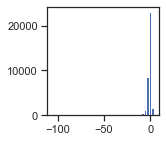

In [45]:
plt.hist(encoding[:, 1], bins=40)

(array([1.2730e+03, 1.1624e+04, 1.5188e+04, 5.4510e+03, 1.3020e+03,
        8.6900e+02, 6.3000e+02, 5.1600e+02, 3.7100e+02, 3.0600e+02,
        2.7200e+02, 1.9200e+02, 1.6900e+02, 1.5800e+02, 1.3600e+02,
        1.1900e+02, 1.2100e+02, 9.4000e+01, 9.4000e+01, 1.0000e+02,
        8.4000e+01, 7.9000e+01, 9.5000e+01, 9.1000e+01, 7.6000e+01,
        7.6000e+01, 7.3000e+01, 6.4000e+01, 6.2000e+01, 7.5000e+01,
        4.5000e+01, 4.1000e+01, 4.3000e+01, 3.9000e+01, 3.1000e+01,
        1.8000e+01, 1.0000e+01, 7.0000e+00, 3.0000e+00, 3.0000e+00]),
 array([-2.055045  , -0.7434988 ,  0.56804734,  1.8795934 ,  3.1911395 ,
         4.5026855 ,  5.814232  ,  7.1257777 ,  8.437324  ,  9.74887   ,
        11.060416  , 12.371963  , 13.683508  , 14.995054  , 16.3066    ,
        17.618147  , 18.929693  , 20.24124   , 21.552786  , 22.86433   ,
        24.175877  , 25.487423  , 26.79897   , 28.110516  , 29.422062  ,
        30.733608  , 32.045155  , 33.3567    , 34.668247  , 35.979794  ,
        37.29134

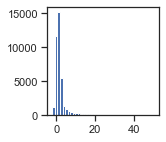

In [46]:
plt.hist(encoding[:, 0], bins=40)

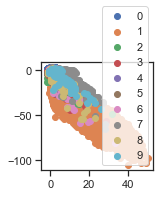

In [39]:
fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    ax.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
ax.legend()


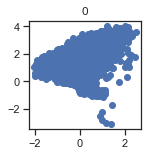

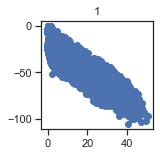

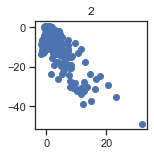

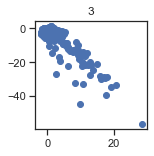

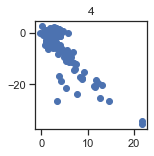

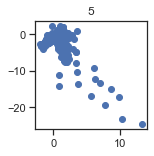

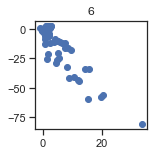

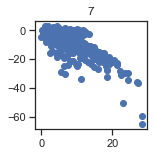

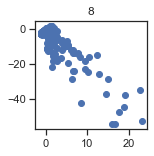

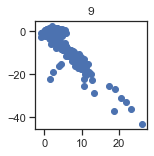

In [40]:
fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    plt.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
    plt.title(f'{i}')
    plt.show()
ax.legend()



In [2]:
# Create a configuration for the dataset
config = {'loss': {'loss_type': 'mse', 'distance_metric': 'mmcd', 'mmd_weight': 1}, 
          'encoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'selu'},
                                  {'num_nodes': 64, 'activation_fn': 'selu'}]}, 
          'decoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'selu'}, 
                                  {'num_nodes': 128, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 2}, 'optimiser': {'params': {}, 'name': 'adam'}}



# Run the VAE 
vae = VAE(test_data, test_data, test_labels, config, 'vae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
vae.encode('default', epochs=100, batch_size=1000)
# get the encoded data
encoding = vae.get_encoded_data()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          100480      default_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128)          512         dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        batch_normalization[0][0]        
____________________________________________________________________________________________

 1/34 [..............................] - ETA: 0s - loss: 818.6351WARNING:tensorflow:From /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
34/34 [==============================] - 2s 70ms/step - loss: 542.9636 - val_loss: 202.4694
Epoch 2/100
34/34 [==============================] - 2s 60ms/step - loss: 224.2397 - val_loss: 155.2091
Epoch 3/100
34/34 [==============================] - 2s 61ms/step - loss: 126.5846 - val_loss: 133.6239
Epoch 4/100
34/34 [==============================] - 2s 65ms/step - loss: 98.5765 - val_loss: 119.2830
Epoch 5/100
34/34 [==============================] - 2s 62ms/step - loss: 88.8778 - val_loss: 109.4528
Epoch 6/100
34/34 [==============================] - 2s 66ms/step - loss: 84.3761 - val_loss: 102.3144
Epoch 7/100
34/34 [===

34/34 [==============================] - 3s 77ms/step - loss: 73.2876 - val_loss: 74.7960
Epoch 78/100
34/34 [==============================] - 2s 73ms/step - loss: 73.1208 - val_loss: 74.9686
Epoch 79/100
34/34 [==============================] - 3s 76ms/step - loss: 73.2441 - val_loss: 74.8853
Epoch 80/100
34/34 [==============================] - 3s 76ms/step - loss: 73.1996 - val_loss: 74.8427
Epoch 81/100
34/34 [==============================] - 3s 74ms/step - loss: 73.1160 - val_loss: 74.9858
Epoch 82/100
34/34 [==============================] - 2s 72ms/step - loss: 73.2040 - val_loss: 74.6848
Epoch 83/100
34/34 [==============================] - 3s 77ms/step - loss: 73.1238 - val_loss: 74.9477
Epoch 84/100
34/34 [==============================] - 3s 75ms/step - loss: 73.0954 - val_loss: 74.9652
Epoch 85/100
34/34 [==============================] - 3s 76ms/step - loss: 72.9832 - val_loss: 74.9401
Epoch 86/100
34/34 [==============================] - 3s 76ms/step - loss: 73.1526 - v

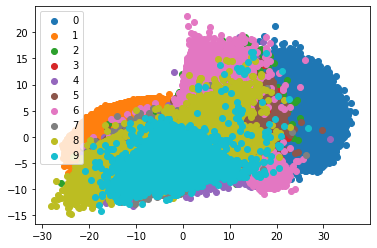

In [3]:
fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    ax.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
ax.legend()


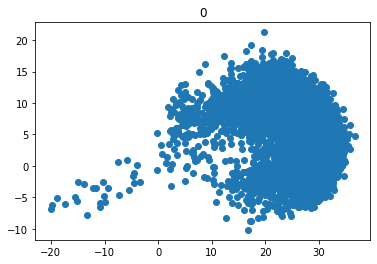

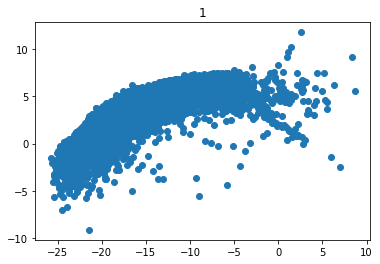

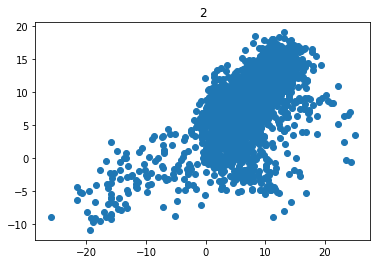

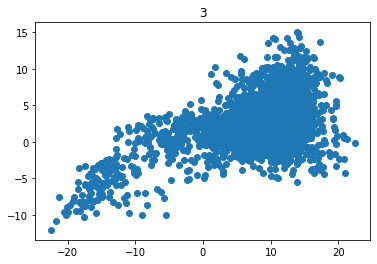

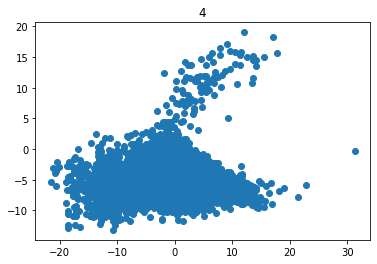

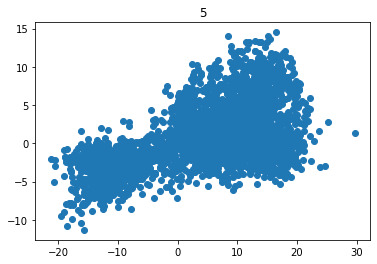

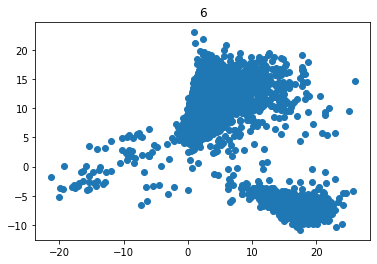

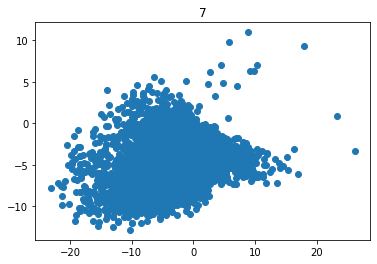

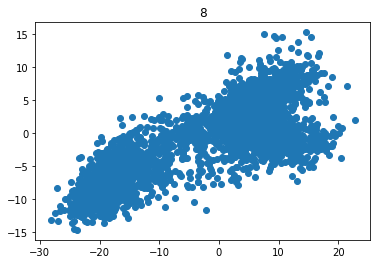

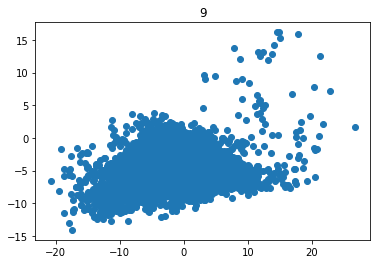

In [4]:
fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    plt.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
    plt.title(f'{i}')
    plt.show()
ax.legend()



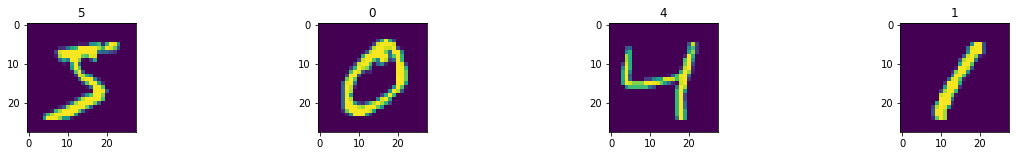

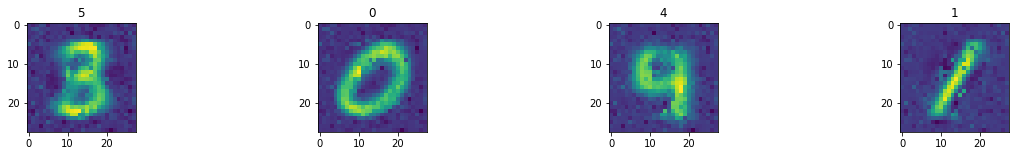

In [6]:
from sklearn.preprocessing import MinMaxScaler
# Show some of the images (4)
n = 4

# Show the true data
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))
    plt.title(test_labels[i])

plt.show()
scaler = MinMaxScaler(copy=True)
test_data_scaled = scaler.fit_transform(test_data)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
encoding_mmcd = vae.encode_new_data(test_data_scaled)[0]

d = vae.decoder.predict(encoding_mmcd)
plt.figure(figsize=(20, 2))
n = 4
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[i,:].reshape(28, 28))
    plt.title(test_labels[i])
plt.show()

In [2]:
# Create a configuration for the dataset
config = {'loss': {'loss_type': 'mse', 'distance_metric': 'mmcd', 'mmd_weight': 1}, 
          'encoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'selu'},
                                  {'num_nodes': 64, 'activation_fn': 'selu'}]}, 
          'decoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'selu'}, 
                                  {'num_nodes': 128, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 2}, 'optimiser': {'params': {}, 'name': 'adam'}}



# Run the VAE 
vae = VAE(test_data, test_data, test_labels, config, 'vae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
vae.encode('default', epochs=100, batch_size=1000)
# get the encoded data
encoding = vae.get_encoded_data()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          100480      default_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128)          512         dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        batch_normalization[0][0]        
____________________________________________________________________________________________

 1/34 [..............................] - ETA: 0s - loss: 818.9509WARNING:tensorflow:From /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
34/34 [==============================] - 3s 80ms/step - loss: 548.2996 - val_loss: 203.1498
Epoch 2/100
34/34 [==============================] - 2s 70ms/step - loss: 227.2054 - val_loss: 154.7840
Epoch 3/100
34/34 [==============================] - 3s 76ms/step - loss: 125.7249 - val_loss: 133.5267
Epoch 4/100
34/34 [==============================] - 3s 77ms/step - loss: 96.5957 - val_loss: 120.2248
Epoch 5/100
34/34 [==============================] - 3s 82ms/step - loss: 87.3757 - val_loss: 110.3985
Epoch 6/100
34/34 [==============================] - 3s 83ms/step - loss: 83.1210 - val_loss: 103.2151
Epoch 7/100
34/34 [===

34/34 [==============================] - 3s 91ms/step - loss: 72.7668 - val_loss: 74.4330
Epoch 78/100
34/34 [==============================] - 3s 89ms/step - loss: 72.6184 - val_loss: 74.6388
Epoch 79/100
34/34 [==============================] - 3s 94ms/step - loss: 72.7597 - val_loss: 74.4702
Epoch 80/100
34/34 [==============================] - 3s 88ms/step - loss: 72.7054 - val_loss: 74.4607
Epoch 81/100
34/34 [==============================] - 3s 90ms/step - loss: 72.5857 - val_loss: 74.5538
Epoch 82/100
34/34 [==============================] - 3s 93ms/step - loss: 72.6427 - val_loss: 74.2719
Epoch 83/100
34/34 [==============================] - 3s 93ms/step - loss: 72.5846 - val_loss: 74.5629
Epoch 84/100
34/34 [==============================] - 3s 92ms/step - loss: 72.5629 - val_loss: 74.6131
Epoch 85/100
34/34 [==============================] - 3s 94ms/step - loss: 72.3751 - val_loss: 74.5146
Epoch 86/100
34/34 [==============================] - 3s 94ms/step - loss: 72.5984 - v

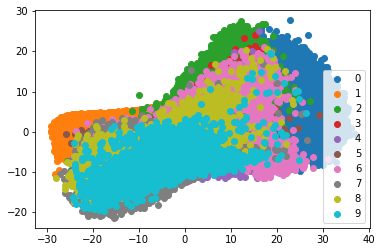

In [3]:
fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    ax.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
ax.legend()


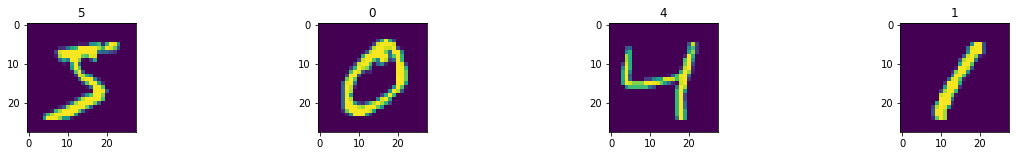

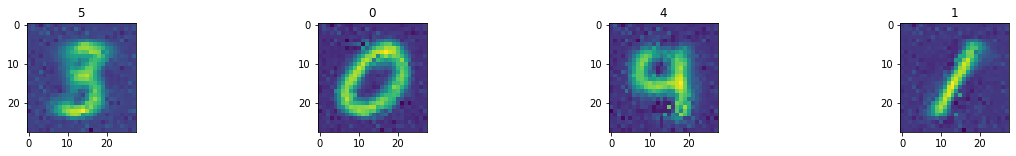

In [4]:
from sklearn.preprocessing import MinMaxScaler
# Show some of the images (4)
n = 4

# Show the true data
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))
    plt.title(test_labels[i])

plt.show()
scaler = MinMaxScaler(copy=True)
test_data_scaled = scaler.fit_transform(test_data)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
encoding_mmcd = vae.encode_new_data(test_data_scaled)[0]

d = vae.decoder.predict(encoding_mmcd)
plt.figure(figsize=(20, 2))
n = 4
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[i,:].reshape(28, 28))
    plt.title(test_labels[i])
plt.show()

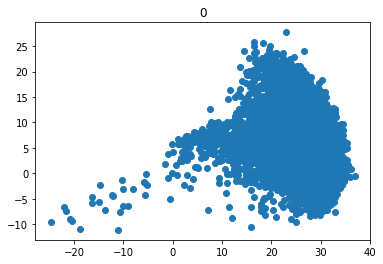

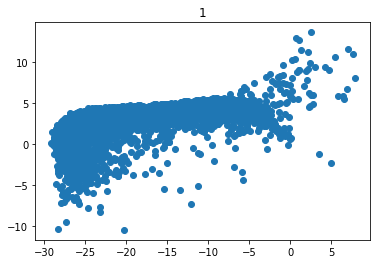

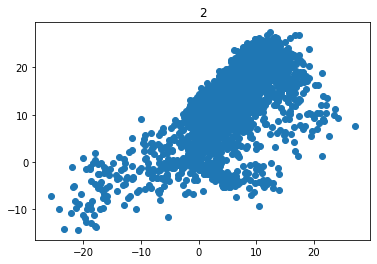

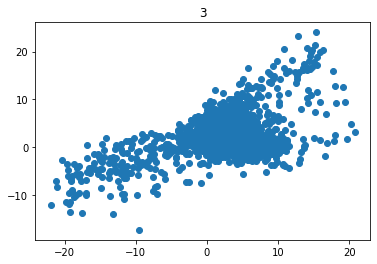

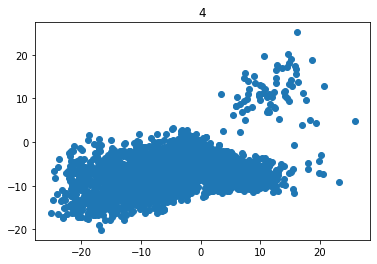

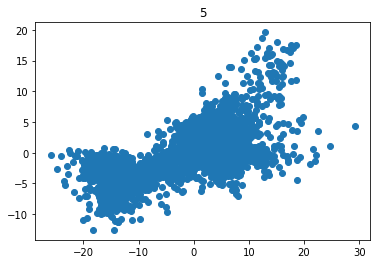

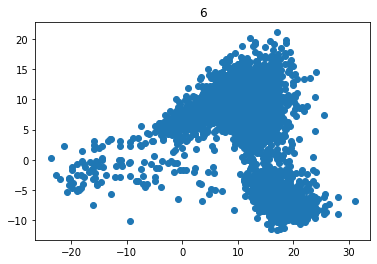

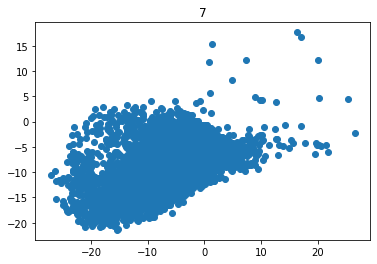

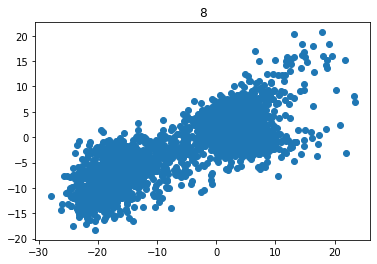

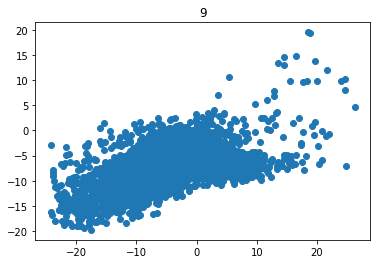

In [5]:
fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    plt.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
    plt.title(f'{i}')
    plt.show()
ax.legend()



Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          100480      default_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128)          512         dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        batch_normalization[0][0]        
____________________________________________________________________________________________

 1/34 [..............................] - ETA: 0s - loss: 817.6483WARNING:tensorflow:From /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
34/34 [==============================] - 2s 70ms/step - loss: 584.6613 - val_loss: 247.1358
Epoch 2/100
34/34 [==============================] - 2s 60ms/step - loss: 313.4008 - val_loss: 163.6969
Epoch 3/100
34/34 [==============================] - 2s 62ms/step - loss: 179.9405 - val_loss: 127.3970
Epoch 4/100
34/34 [==============================] - 2s 65ms/step - loss: 125.2034 - val_loss: 112.7867
Epoch 5/100
34/34 [==============================] - 2s 68ms/step - loss: 102.3442 - val_loss: 104.8736
Epoch 6/100
34/34 [==============================] - 2s 71ms/step - loss: 91.9943 - val_loss: 99.5579
Epoch 7/100
34/34 [==

34/34 [==============================] - 3s 75ms/step - loss: 74.4314 - val_loss: 75.2163
Epoch 78/100
34/34 [==============================] - 2s 70ms/step - loss: 74.2758 - val_loss: 75.2907
Epoch 79/100
34/34 [==============================] - 3s 75ms/step - loss: 74.3759 - val_loss: 75.0835
Epoch 80/100
34/34 [==============================] - 3s 76ms/step - loss: 74.3244 - val_loss: 75.0930
Epoch 81/100
34/34 [==============================] - 3s 80ms/step - loss: 74.2525 - val_loss: 75.2193
Epoch 82/100
34/34 [==============================] - 3s 81ms/step - loss: 74.3179 - val_loss: 74.9393
Epoch 83/100
34/34 [==============================] - 3s 76ms/step - loss: 74.2637 - val_loss: 75.1700
Epoch 84/100
34/34 [==============================] - 3s 80ms/step - loss: 74.2540 - val_loss: 75.1828
Epoch 85/100
34/34 [==============================] - 3s 80ms/step - loss: 74.0603 - val_loss: 75.0806
Epoch 86/100
34/34 [==============================] - 3s 84ms/step - loss: 74.2945 - v

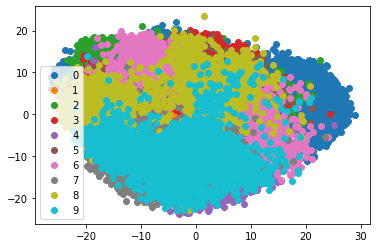

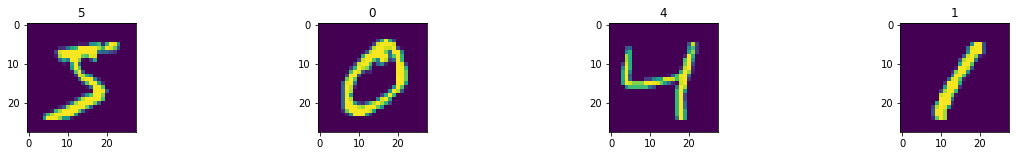

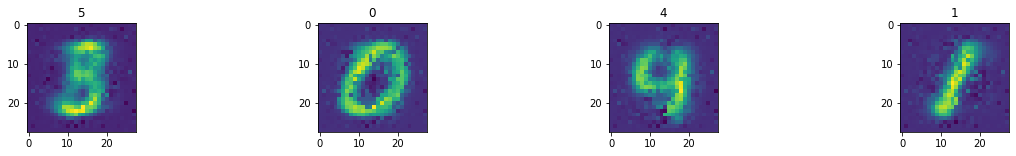

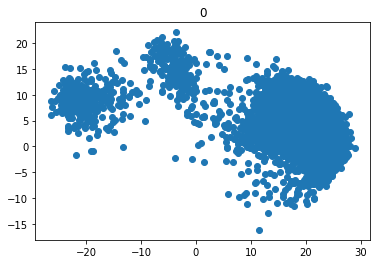

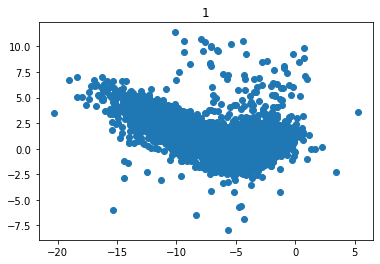

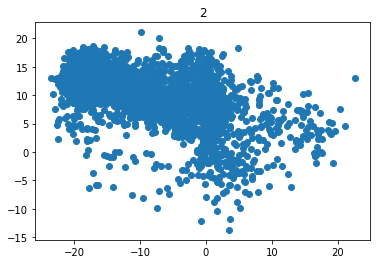

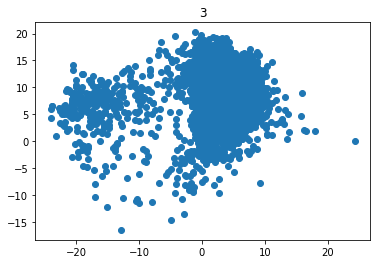

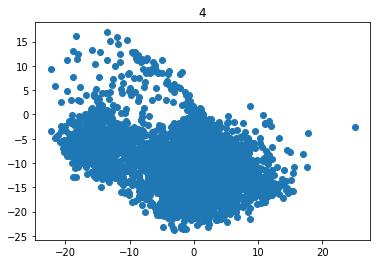

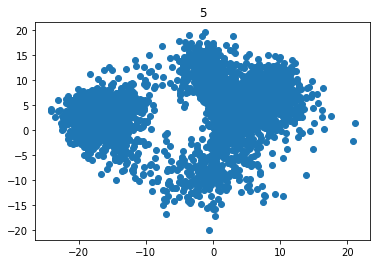

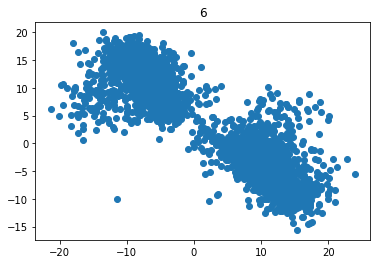

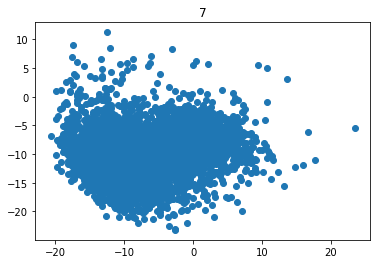

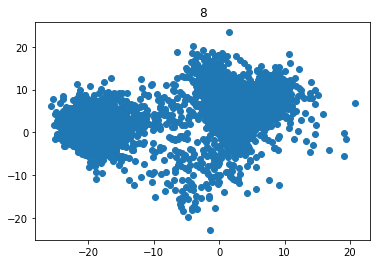

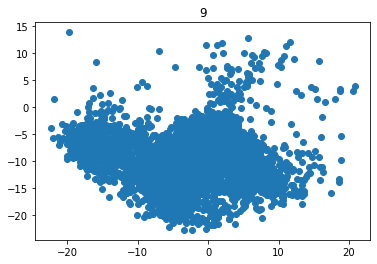

In [2]:
# Create a configuration for the dataset
config = {'loss': {'loss_type': 'mse', 'distance_metric': 'mmcd', 'mmd_weight': 1}, 
          'encoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'selu'},
                                  {'num_nodes': 64, 'activation_fn': 'selu'}]}, 
          'decoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'selu'}, 
                                  {'num_nodes': 128, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 2}, 'optimiser': {'params': {}, 'name': 'adam'}}



# Run the VAE 
vae = VAE(test_data, test_data, test_labels, config, 'vae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
vae.encode('default', epochs=100, batch_size=1000)
# get the encoded data
encoding = vae.get_encoded_data()


fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    ax.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
ax.legend()


from sklearn.preprocessing import MinMaxScaler
# Show some of the images (4)
n = 4

# Show the true data
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))
    plt.title(test_labels[i])

plt.show()
scaler = MinMaxScaler(copy=True)
test_data_scaled = scaler.fit_transform(test_data)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
encoding_mmcd = vae.encode_new_data(test_data_scaled)[0]

d = vae.decoder.predict(encoding_mmcd)
plt.figure(figsize=(20, 2))
n = 4
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[i,:].reshape(28, 28))
    plt.title(test_labels[i])
plt.show()

fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    plt.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
    plt.title(f'{i}')
    plt.show()
ax.legend()




Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          100480      default_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128)          512         dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        batch_normalization[0][0]        
____________________________________________________________________________________________

 1/34 [..............................] - ETA: 0s - loss: 918.7690WARNING:tensorflow:From /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
34/34 [==============================] - 2s 69ms/step - loss: 660.5107 - val_loss: 328.6712
Epoch 2/100
34/34 [==============================] - 2s 61ms/step - loss: 382.9169 - val_loss: 240.9010
Epoch 3/100
34/34 [==============================] - 2s 60ms/step - loss: 250.2412 - val_loss: 207.5952
Epoch 4/100
34/34 [==============================] - 2s 64ms/step - loss: 201.8097 - val_loss: 192.9416
Epoch 5/100
34/34 [==============================] - 2s 63ms/step - loss: 182.1611 - val_loss: 184.3334
Epoch 6/100
34/34 [==============================] - 2s 65ms/step - loss: 172.2916 - val_loss: 178.2612
Epoch 7/100
34/34 [

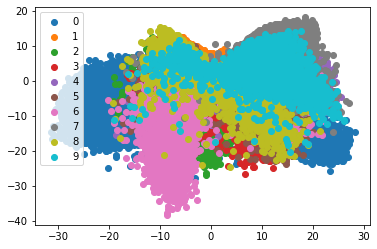

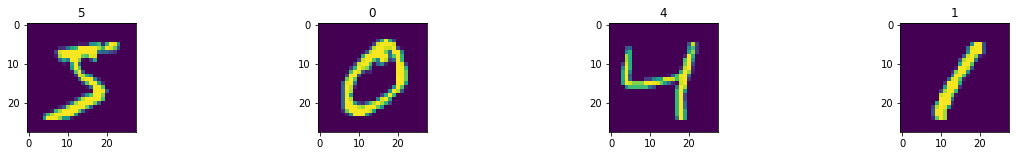

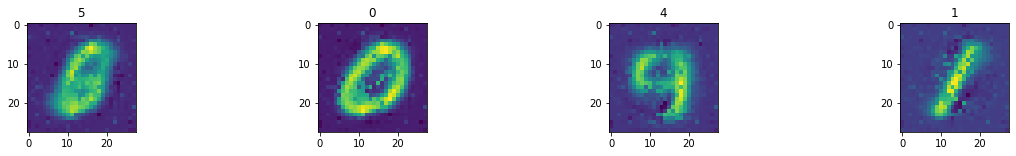

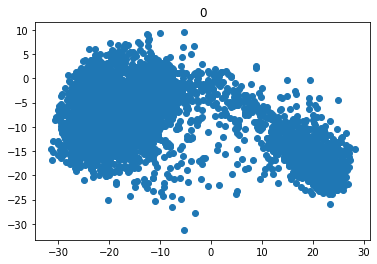

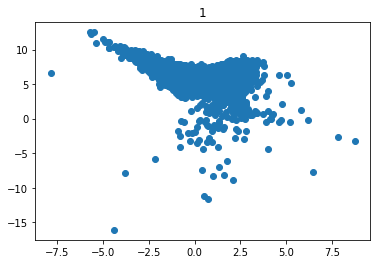

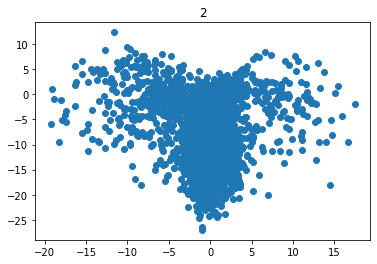

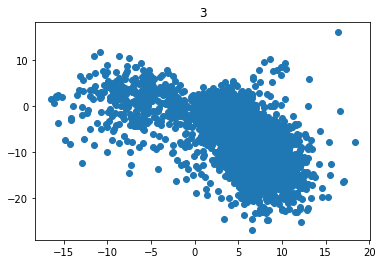

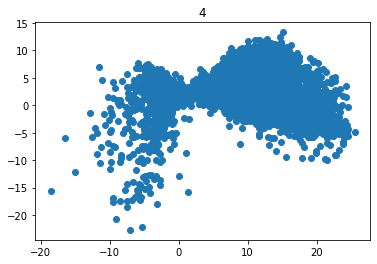

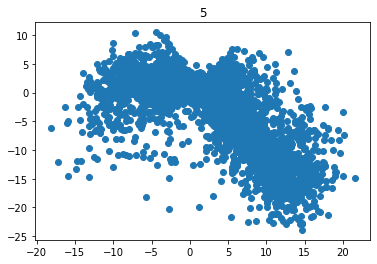

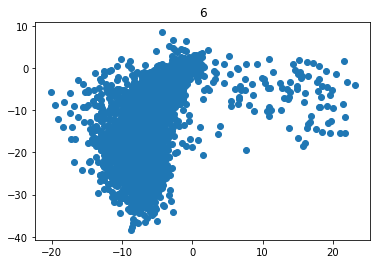

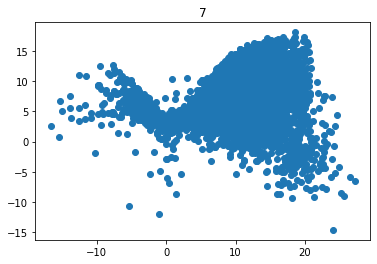

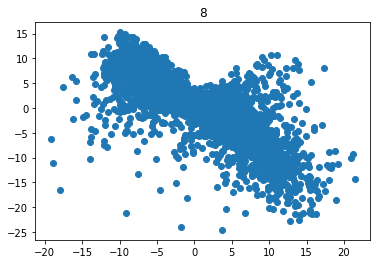

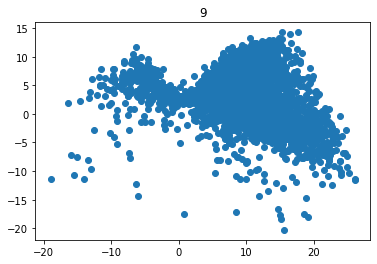

In [2]:
# Create a configuration for the dataset
config = {'loss': {'loss_type': 'mse', 'distance_metric': 'mmcd', 'mmd_weight': 1.0, 'beta': 10}, 
          'encoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'selu'},
                                  {'num_nodes': 64, 'activation_fn': 'selu'}]}, 
          'decoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'selu'}, 
                                  {'num_nodes': 128, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 2}, 'optimiser': {'params': {}, 'name': 'adam'}}



# Run the VAE 
vae = VAE(test_data, test_data, test_labels, config, 'vae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
vae.encode('default', epochs=100, batch_size=1000)
# get the encoded data
encoding = vae.get_encoded_data()


fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    ax.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
ax.legend()


from sklearn.preprocessing import MinMaxScaler
# Show some of the images (4)
n = 4

# Show the true data
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))
    plt.title(test_labels[i])

plt.show()
scaler = MinMaxScaler(copy=True)
test_data_scaled = scaler.fit_transform(test_data)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
encoding_mmcd = vae.encode_new_data(test_data_scaled)[0]

d = vae.decoder.predict(encoding_mmcd)
plt.figure(figsize=(20, 2))
n = 4
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[i,:].reshape(28, 28))
    plt.title(test_labels[i])
plt.show()

fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    plt.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
    plt.title(f'{i}')
    plt.show()
ax.legend()




Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          100480      default_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 128)          512         dense_10[0][0]                   
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 64)           8256        batch_normalization_10[0][0]     
____________________________________________________________________________________________

 2/34 [>.............................] - ETA: 3s - loss: 800.8868WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0609s vs `on_train_batch_end` time: 0.1651s). Check your callbacks.


34/34 [==============================] - 3s 74ms/step - loss: 549.4531 - val_loss: 203.3292
Epoch 2/100
34/34 [==============================] - 2s 62ms/step - loss: 245.6636 - val_loss: 153.6742
Epoch 3/100
34/34 [==============================] - 2s 63ms/step - loss: 135.9572 - val_loss: 131.3944
Epoch 4/100
34/34 [==============================] - 2s 64ms/step - loss: 102.2085 - val_loss: 118.2550
Epoch 5/100
34/34 [==============================] - 2s 62ms/step - loss: 90.2173 - val_loss: 109.2009
Epoch 6/100
34/34 [==============================] - 2s 72ms/step - loss: 84.8955 - val_loss: 102.4008
Epoch 7/100
34/34 [==============================] - 2s 64ms/step - loss: 82.1101 - val_loss: 97.9238
Epoch 8/100
34/34 [==============================] - 2s 65ms/step - loss: 80.6978 - val_loss: 94.1290
Epoch 9/100
34/34 [==============================] - 2s 68ms/step - loss: 79.7349 - val_loss: 91.2156
Epoch 10/100
34/34 [==============================] - 2s 65ms/step - loss: 79.2030 -

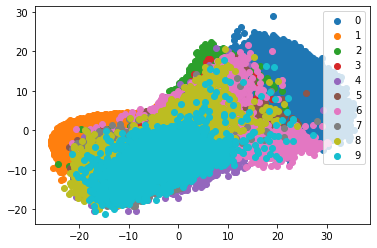

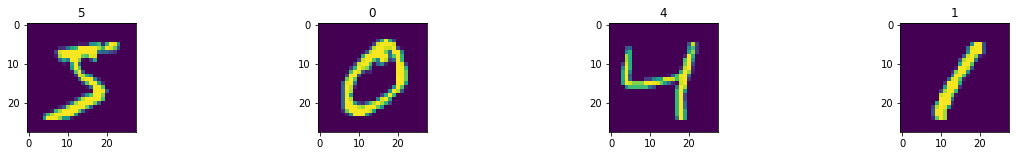

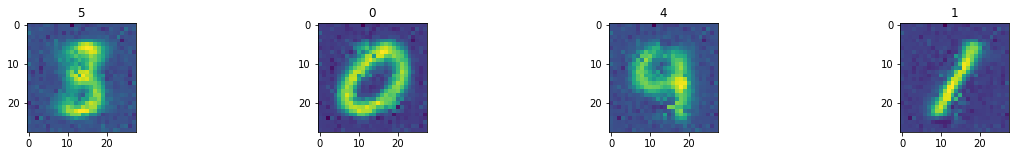

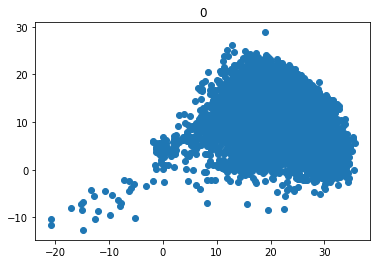

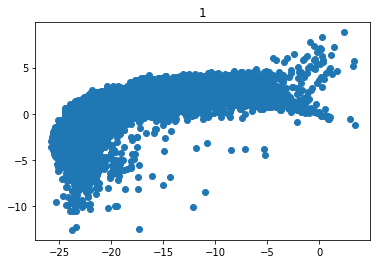

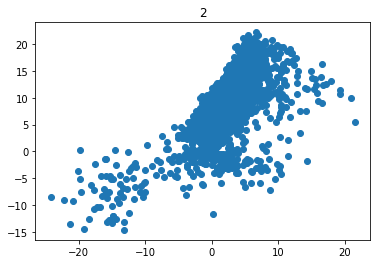

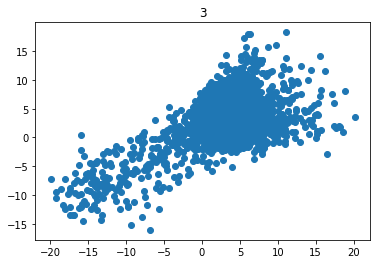

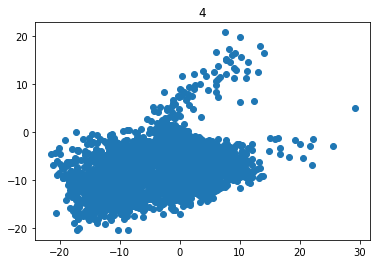

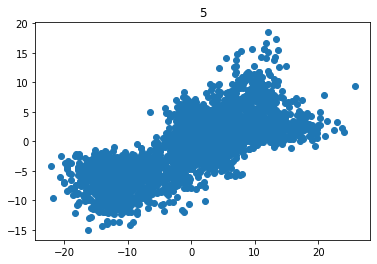

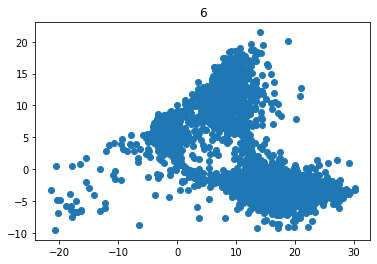

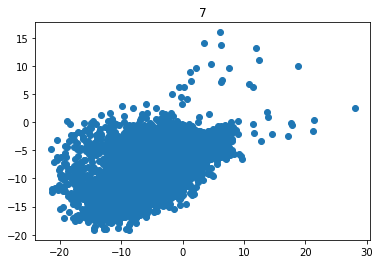

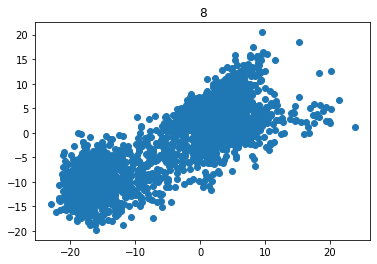

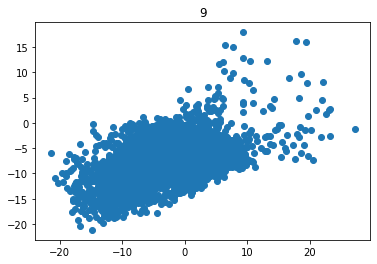

In [5]:
# Create a configuration for the dataset
config = {'loss': {'loss_type': 'mse', 'distance_metric': 'mmcd', 'mmd_weight': 1.0, 'beta': 1.0}, 
          'encoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'selu'},
                                  {'num_nodes': 64, 'activation_fn': 'selu'}]}, 
          'decoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'selu'}, 
                                  {'num_nodes': 128, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 2}, 'optimiser': {'params': {}, 'name': 'adam'}}



# Run the VAE 
vae = VAE(test_data, test_data, test_labels, config, 'vae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
vae.encode('default', epochs=100, batch_size=1000)
# get the encoded data
encoding = vae.get_encoded_data()


fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    ax.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
ax.legend()


from sklearn.preprocessing import MinMaxScaler
# Show some of the images (4)
n = 4

# Show the true data
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))
    plt.title(test_labels[i])

plt.show()
scaler = MinMaxScaler(copy=True)
test_data_scaled = scaler.fit_transform(test_data)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
encoding_mmcd = vae.encode_new_data(test_data_scaled)[0]

d = vae.decoder.predict(encoding_mmcd)
plt.figure(figsize=(20, 2))
n = 4
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[i,:].reshape(28, 28))
    plt.title(test_labels[i])
plt.show()

fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    plt.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
    plt.title(f'{i}')
    plt.show()
ax.legend()




Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          100480      default_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128)          512         dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        batch_normalization[0][0]        
____________________________________________________________________________________________

 1/34 [..............................] - ETA: 0s - loss: 1213.0780WARNING:tensorflow:From /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
34/34 [==============================] - 2s 59ms/step - loss: 598.9267 - val_loss: 223.4229
Epoch 2/100
34/34 [==============================] - 2s 54ms/step - loss: 253.7643 - val_loss: 157.6704
Epoch 3/100
34/34 [==============================] - 2s 61ms/step - loss: 141.5093 - val_loss: 134.6268
Epoch 4/100
34/34 [==============================] - 2s 61ms/step - loss: 107.5308 - val_loss: 120.2501
Epoch 5/100
34/34 [==============================] - 2s 63ms/step - loss: 94.4039 - val_loss: 110.1928
Epoch 6/100
34/34 [==============================] - 2s 61ms/step - loss: 88.4248 - val_loss: 103.4436
Epoch 7/100
34/34 [=

34/34 [==============================] - 2s 68ms/step - loss: 72.5421 - val_loss: 73.4495
Epoch 78/100
34/34 [==============================] - 2s 64ms/step - loss: 72.4200 - val_loss: 73.2636
Epoch 79/100
34/34 [==============================] - 2s 68ms/step - loss: 72.3616 - val_loss: 73.2426
Epoch 80/100
34/34 [==============================] - 2s 69ms/step - loss: 72.2947 - val_loss: 73.2149
Epoch 81/100
34/34 [==============================] - 2s 64ms/step - loss: 72.3221 - val_loss: 73.2190
Epoch 82/100
34/34 [==============================] - 2s 70ms/step - loss: 72.2588 - val_loss: 73.1498
Epoch 83/100
34/34 [==============================] - 2s 69ms/step - loss: 72.3001 - val_loss: 73.2460
Epoch 84/100
34/34 [==============================] - 2s 67ms/step - loss: 72.2082 - val_loss: 73.1113
Epoch 85/100
34/34 [==============================] - 2s 69ms/step - loss: 72.1891 - val_loss: 73.0339
Epoch 86/100
34/34 [==============================] - 2s 68ms/step - loss: 72.1706 - v

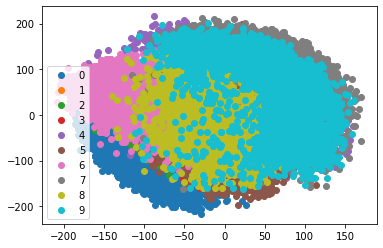

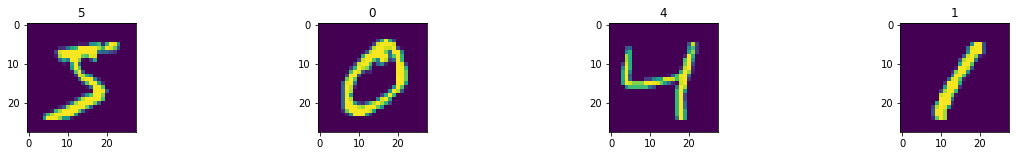

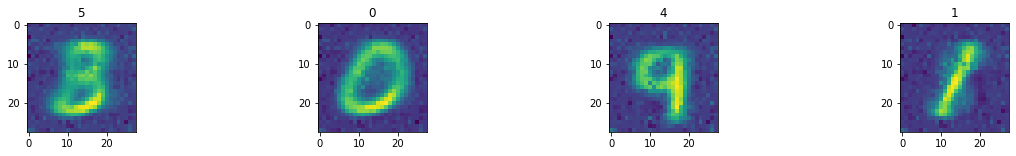

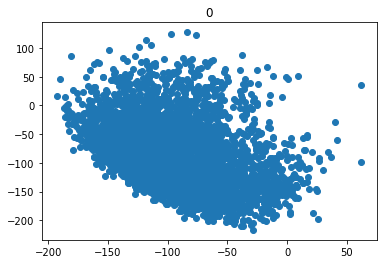

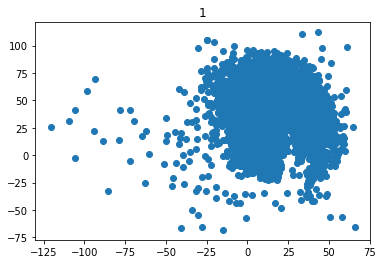

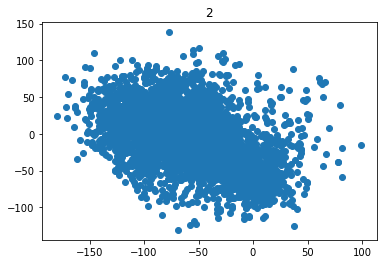

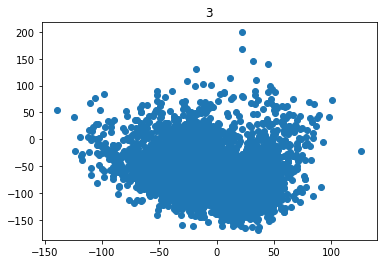

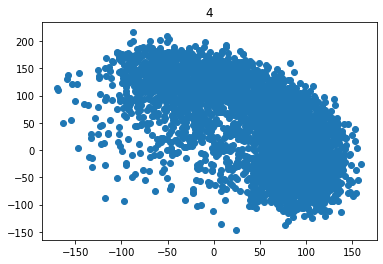

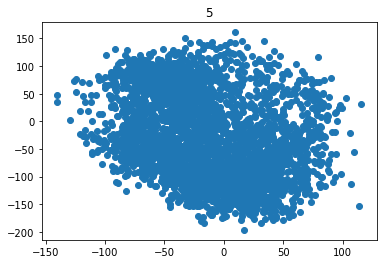

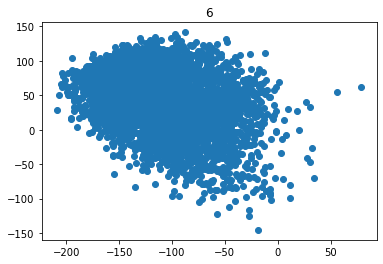

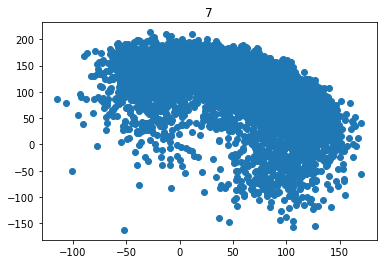

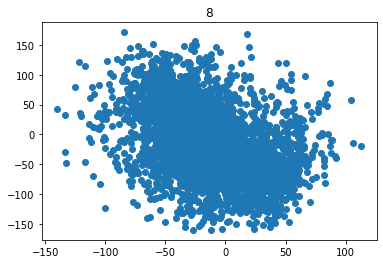

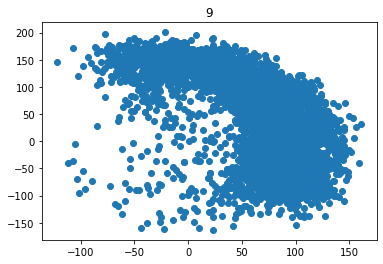

In [2]:
# Create a configuration for the dataset
config = {'loss': {'loss_type': 'mse', 'distance_metric': 'mmcd', 'mmd_weight': 1.0, 'beta': 1.0}, 
          'encoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'selu'},
                                  {'num_nodes': 64, 'activation_fn': 'selu'}]}, 
          'decoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'selu'}, 
                                  {'num_nodes': 128, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 2}, 'optimiser': {'params': {}, 'name': 'adam'}}



# Run the VAE 
vae = VAE(test_data, test_data, test_labels, config, 'vae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
vae.encode('default', epochs=100, batch_size=1000)
# get the encoded data
encoding = vae.get_encoded_data()


fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    ax.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
ax.legend()


from sklearn.preprocessing import MinMaxScaler
# Show some of the images (4)
n = 4

# Show the true data
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))
    plt.title(test_labels[i])

plt.show()
scaler = MinMaxScaler(copy=True)
test_data_scaled = scaler.fit_transform(test_data)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
encoding_mmcd = vae.encode_new_data(test_data_scaled)[0]

d = vae.decoder.predict(encoding_mmcd)
plt.figure(figsize=(20, 2))
n = 4
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[i,:].reshape(28, 28))
    plt.title(test_labels[i])
plt.show()

fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    plt.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
    plt.title(f'{i}')
    plt.show()
ax.legend()




Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          100480      default_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 128)          512         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 64)           8256        batch_normalization_5[0][0]      
____________________________________________________________________________________________

Epoch 1/100
34/34 [==============================] - 2s 48ms/step - loss: 509.1457 - val_loss: 178.0970
Epoch 2/100
34/34 [==============================] - 1s 43ms/step - loss: 200.4828 - val_loss: 107.1107
Epoch 3/100
34/34 [==============================] - 1s 41ms/step - loss: 99.4384 - val_loss: 91.0513
Epoch 4/100
34/34 [==============================] - 1s 41ms/step - loss: 69.1315 - val_loss: 80.0723
Epoch 5/100
34/34 [==============================] - 1s 38ms/step - loss: 57.5473 - val_loss: 72.3089
Epoch 6/100
34/34 [==============================] - 1s 37ms/step - loss: 52.1588 - val_loss: 66.7429
Epoch 7/100
34/34 [==============================] - 1s 40ms/step - loss: 49.5423 - val_loss: 62.5932
Epoch 8/100
34/34 [==============================] - 1s 37ms/step - loss: 48.1060 - val_loss: 59.4882
Epoch 9/100
34/34 [==============================] - 1s 42ms/step - loss: 47.2327 - val_loss: 57.1286
Epoch 10/100
34/34 [==============================] - 1s 37ms/step - loss: 46.

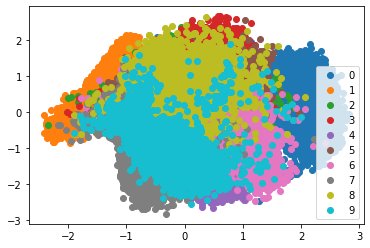

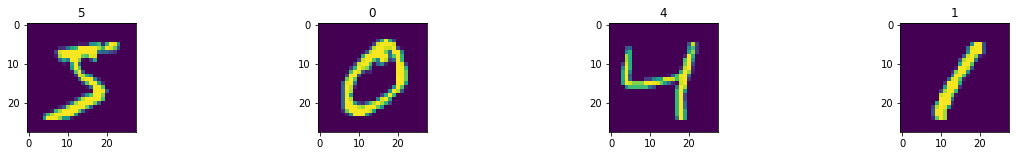

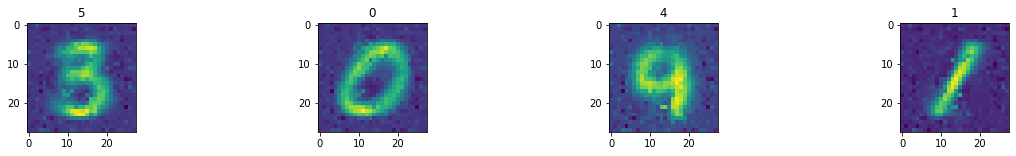

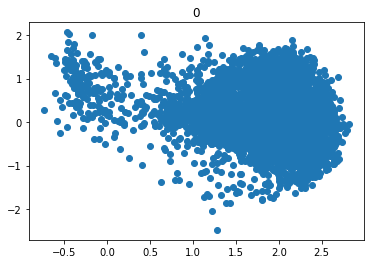

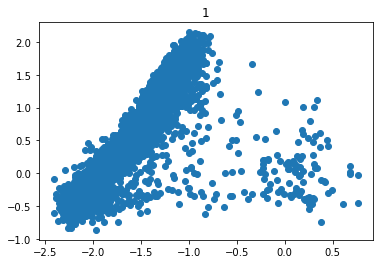

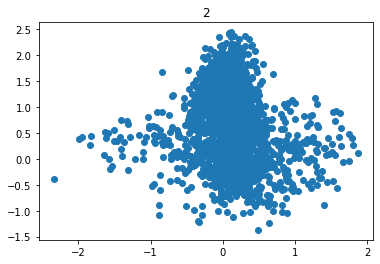

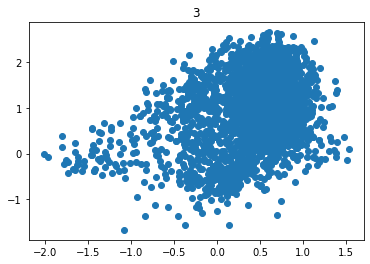

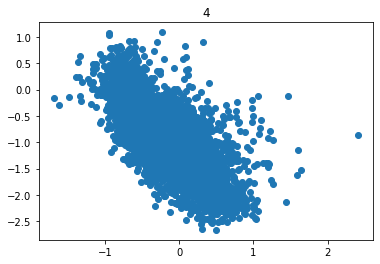

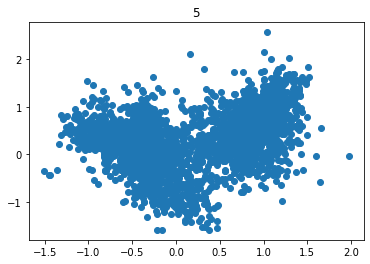

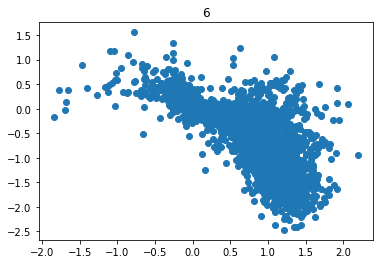

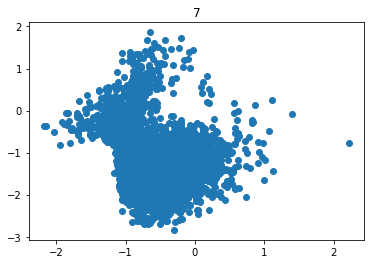

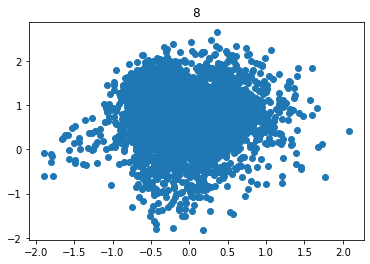

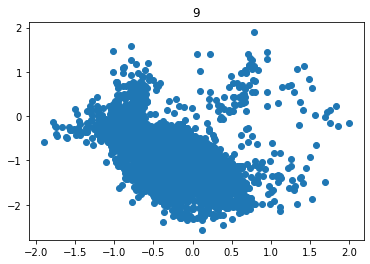

In [3]:
# Create a configuration for the dataset
config = {'loss': {'loss_type': 'mse', 'distance_metric': 'kl', 'mmd_weight': 1.0, 'beta': 1.0}, 
          'encoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'selu'},
                                  {'num_nodes': 64, 'activation_fn': 'selu'}]}, 
          'decoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'selu'}, 
                                  {'num_nodes': 128, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 2}, 'optimiser': {'params': {}, 'name': 'adam'}}



# Run the VAE 
vae = VAE(test_data, test_data, test_labels, config, 'vae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
vae.encode('default', epochs=100, batch_size=1000)
# get the encoded data
encoding = vae.get_encoded_data()


fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    ax.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
ax.legend()


from sklearn.preprocessing import MinMaxScaler
# Show some of the images (4)
n = 4

# Show the true data
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))
    plt.title(test_labels[i])

plt.show()
scaler = MinMaxScaler(copy=True)
test_data_scaled = scaler.fit_transform(test_data)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
encoding_mmcd = vae.encode_new_data(test_data_scaled)[0]

d = vae.decoder.predict(encoding_mmcd)
plt.figure(figsize=(20, 2))
n = 4
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[i,:].reshape(28, 28))
    plt.title(test_labels[i])
plt.show()

fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    plt.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
    plt.title(f'{i}')
    plt.show()
ax.legend()

plt.figure(figsize=(50, 2))
fig, ax = plt.subplots()
n = 5
for i in range(n):
    sample_n = [[np.random.normal(), np.random.normal()]]
    d = vae.decoder.predict(sample_n)

    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[0,:].reshape(28, 28))
    plt.title(test_labels[i])
plt.show()


<Figure size 3600x144 with 0 Axes>

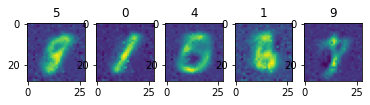

In [21]:
# Should sample from 0-1 normal dist and see how well it decodes it


plt.figure(figsize=(50, 2))
fig, ax = plt.subplots()
n = 5
for i in range(n):
    sample_n = [[np.random.normal(), np.random.normal()]]
    d = vae.decoder.predict(sample_n)

    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[0,:].reshape(28, 28))
    plt.title(test_labels[i])
plt.show()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          100480      default_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 128)          512         dense_10[0][0]                   
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 64)           8256        batch_normalization_10[0][0]     
____________________________________________________________________________________________

34/34 [==============================] - 3s 85ms/step - loss: 598.8303 - val_loss: 229.1862
Epoch 2/100
34/34 [==============================] - 2s 73ms/step - loss: 233.8429 - val_loss: 159.8315
Epoch 3/100
34/34 [==============================] - 2s 73ms/step - loss: 127.6241 - val_loss: 134.9512
Epoch 4/100
34/34 [==============================] - 2s 69ms/step - loss: 100.8867 - val_loss: 121.1225
Epoch 5/100
34/34 [==============================] - 2s 71ms/step - loss: 91.4388 - val_loss: 111.6506
Epoch 6/100
34/34 [==============================] - 2s 72ms/step - loss: 87.0164 - val_loss: 104.1421
Epoch 7/100
34/34 [==============================] - 2s 72ms/step - loss: 84.5329 - val_loss: 99.0183
Epoch 8/100
34/34 [==============================] - 2s 71ms/step - loss: 82.9198 - val_loss: 95.4126
Epoch 9/100
34/34 [==============================] - 2s 71ms/step - loss: 82.0198 - val_loss: 92.5005
Epoch 10/100
34/34 [==============================] - 2s 71ms/step - loss: 81.3050 -

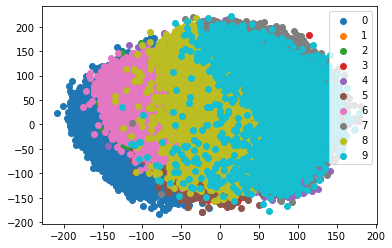

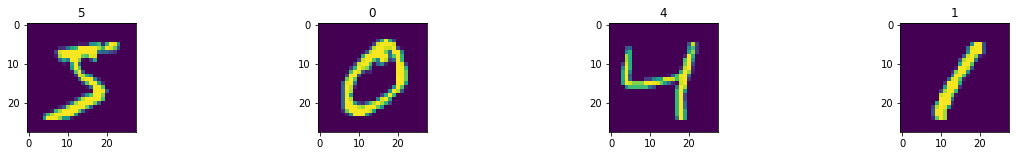

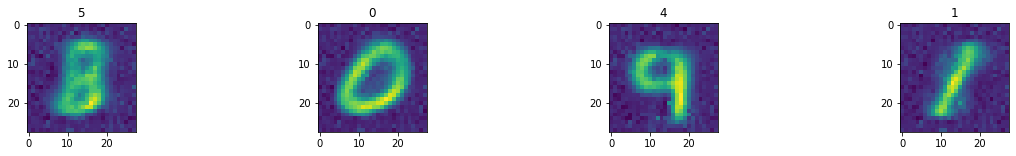

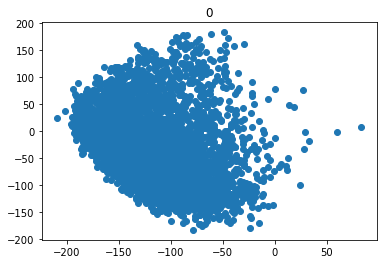

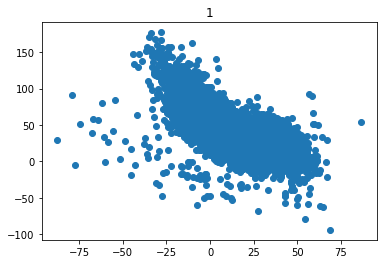

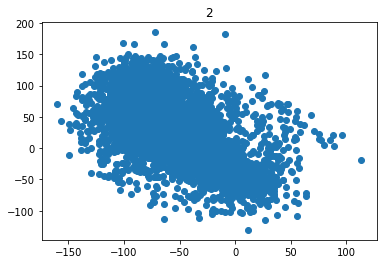

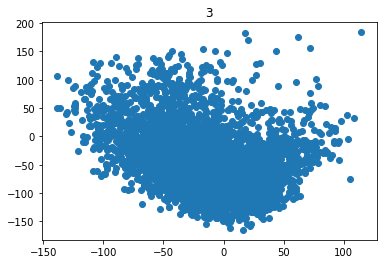

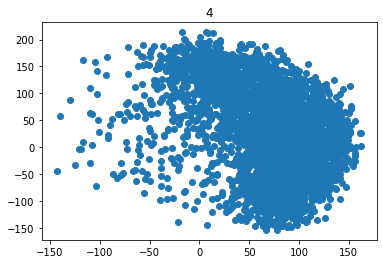

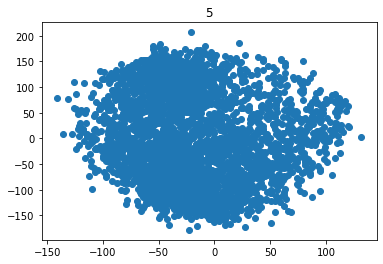

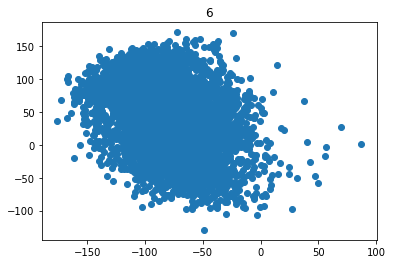

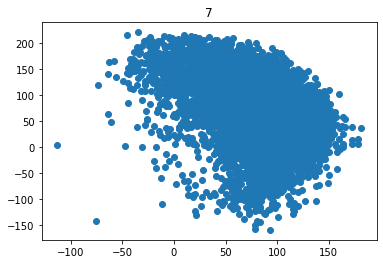

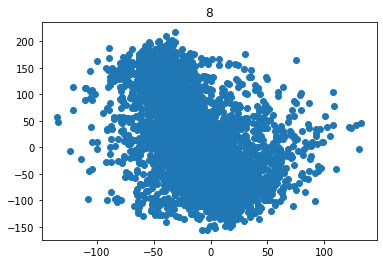

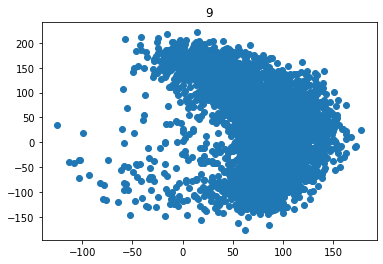

<Figure size 3600x144 with 0 Axes>

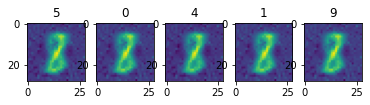

In [22]:
# Create a configuration for the dataset
config = {'loss': {'loss_type': 'mse', 'distance_metric': 'mmcd', 'mmd_weight': 1.0, 'beta': 1.0}, 
          'encoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'selu'},
                                  {'num_nodes': 64, 'activation_fn': 'selu'}]}, 
          'decoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'selu'}, 
                                  {'num_nodes': 128, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 2}, 'optimiser': {'params': {}, 'name': 'adam'}}



# Run the VAE 
vae = VAE(test_data, test_data, test_labels, config, 'vae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
vae.encode('default', epochs=100, batch_size=1000)
# get the encoded data
encoding = vae.get_encoded_data()


fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    ax.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
ax.legend()


from sklearn.preprocessing import MinMaxScaler
# Show some of the images (4)
n = 4

# Show the true data
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))
    plt.title(test_labels[i])

plt.show()
scaler = MinMaxScaler(copy=True)
test_data_scaled = scaler.fit_transform(test_data)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
encoding_mmcd = vae.encode_new_data(test_data_scaled)[0]

d = vae.decoder.predict(encoding_mmcd)
plt.figure(figsize=(20, 2))
n = 4
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[i,:].reshape(28, 28))
    plt.title(test_labels[i])
plt.show()

fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    plt.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
    plt.title(f'{i}')
    plt.show()
ax.legend()

plt.figure(figsize=(50, 2))
fig, ax = plt.subplots()
n = 5
for i in range(n):
    sample_n = [[np.random.normal(), np.random.normal()]]
    d = vae.decoder.predict(sample_n)

    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[0,:].reshape(28, 28))
    plt.title(test_labels[i])
plt.show()


[[-252.1918164560279, 41.277532186408045]]
[[68.85865490620003, -9.559667604849048]]
[[21.790612522768377, -37.22767984202892]]
[[8.31751712390979, -20.86095761881437]]
[[-6.423663764051844, 57.7510674640313]]


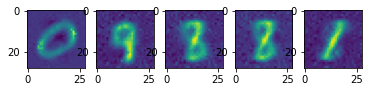

In [31]:
n = 5
for i in range(n):
    sample_n = [[np.random.normal(0, 100), np.random.normal(0, 100)]]
    d = vae.decoder.predict(sample_n)
    
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[0,:].reshape(28, 28))
    print(sample_n)
plt.show()

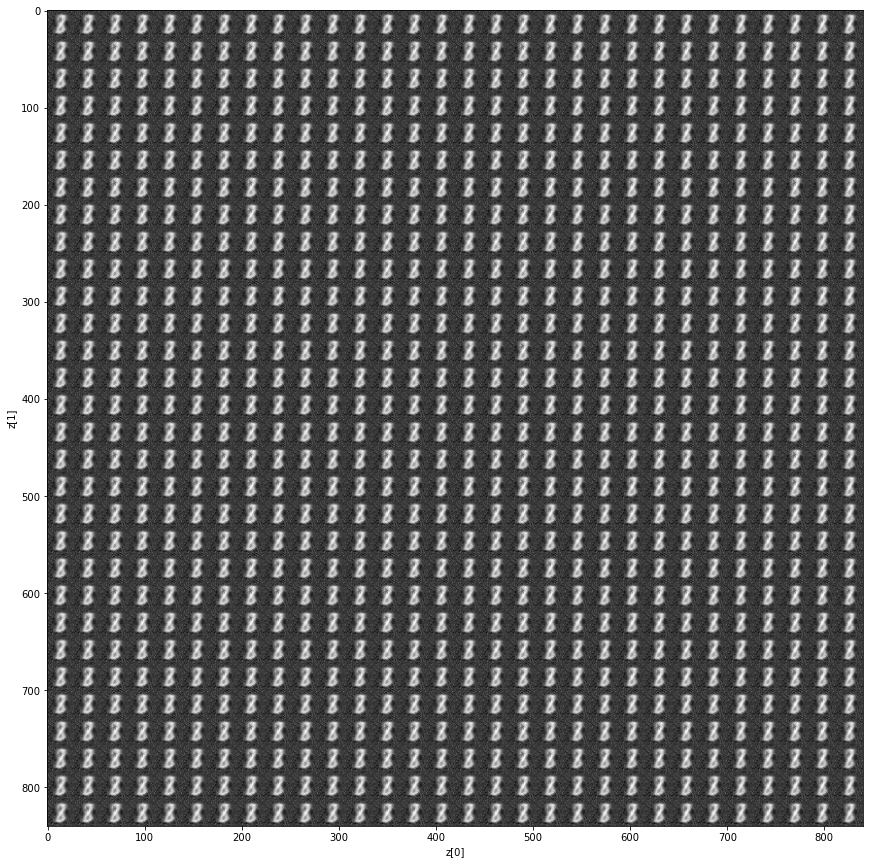

In [34]:
def plot_latent(decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
#     plt.xticks(pixel_range, sample_range_x)
#     plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(vae.decoder)

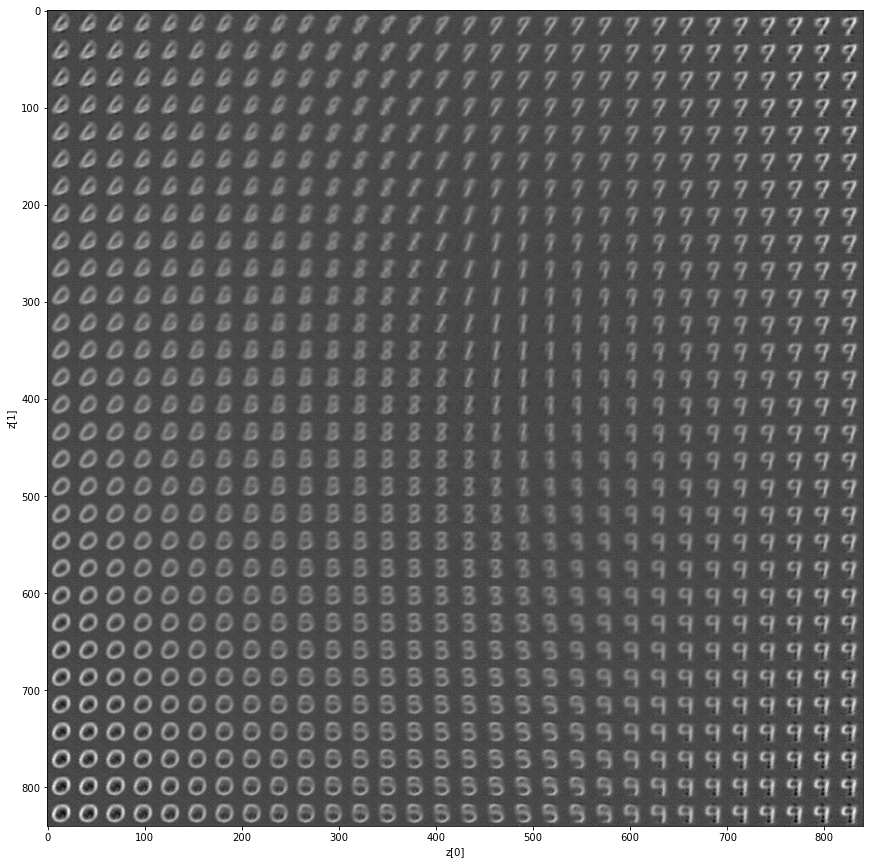

In [37]:
def plot_latent(decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 150.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
#     plt.xticks(pixel_range, sample_range_x)
#     plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(vae.decoder)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          100480      default_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 128)          512         dense_10[0][0]                   
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 64)           8256        batch_normalization_10[0][0]     
____________________________________________________________________________________________

 2/34 [>.............................] - ETA: 2s - loss: 776.8798WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0258s vs `on_train_batch_end` time: 0.1069s). Check your callbacks.


34/34 [==============================] - 1s 37ms/step - loss: 315.3841 - val_loss: 135.6746
Epoch 2/500
34/34 [==============================] - 1s 27ms/step - loss: 65.7398 - val_loss: 93.6056
Epoch 3/500
34/34 [==============================] - 1s 29ms/step - loss: 38.3476 - val_loss: 81.0484
Epoch 4/500
34/34 [==============================] - 1s 26ms/step - loss: 34.6008 - val_loss: 72.6129
Epoch 5/500
34/34 [==============================] - 1s 27ms/step - loss: 32.8078 - val_loss: 66.2679
Epoch 6/500
34/34 [==============================] - 1s 27ms/step - loss: 31.7430 - val_loss: 61.3987
Epoch 7/500
34/34 [==============================] - 1s 27ms/step - loss: 31.0164 - val_loss: 57.8279
Epoch 8/500
34/34 [==============================] - 1s 26ms/step - loss: 30.4397 - val_loss: 55.0416
Epoch 9/500
34/34 [==============================] - 1s 25ms/step - loss: 29.9904 - val_loss: 52.9251
Epoch 10/500
34/34 [==============================] - 1s 26ms/step - loss: 29.4766 - val_los

34/34 [==============================] - 1s 30ms/step - loss: 21.3201 - val_loss: 22.4936
Epoch 160/500
34/34 [==============================] - 1s 30ms/step - loss: 21.3085 - val_loss: 22.4556
Epoch 161/500
34/34 [==============================] - 1s 30ms/step - loss: 21.2868 - val_loss: 22.4007
Epoch 162/500
34/34 [==============================] - 1s 27ms/step - loss: 21.2942 - val_loss: 22.3747
Epoch 163/500
34/34 [==============================] - 1s 29ms/step - loss: 21.2839 - val_loss: 22.3619
Epoch 164/500
34/34 [==============================] - 1s 29ms/step - loss: 21.2382 - val_loss: 22.3133
Epoch 165/500
34/34 [==============================] - 1s 30ms/step - loss: 21.2422 - val_loss: 22.3002
Epoch 166/500
34/34 [==============================] - 1s 28ms/step - loss: 21.2151 - val_loss: 22.2292
Epoch 167/500
34/34 [==============================] - 1s 31ms/step - loss: 21.1994 - val_loss: 22.1866
Epoch 168/500
34/34 [==============================] - 1s 30ms/step - loss: 21

Epoch 238/500
34/34 [==============================] - 1s 27ms/step - loss: 20.3949 - val_loss: 20.8013
Epoch 239/500
34/34 [==============================] - 1s 30ms/step - loss: 20.3702 - val_loss: 20.7854
Epoch 240/500
34/34 [==============================] - 1s 31ms/step - loss: 20.3678 - val_loss: 20.7848
Epoch 241/500
34/34 [==============================] - 1s 34ms/step - loss: 20.3683 - val_loss: 20.7603
Epoch 242/500
34/34 [==============================] - 1s 29ms/step - loss: 20.3518 - val_loss: 20.7402
Epoch 243/500
34/34 [==============================] - 1s 31ms/step - loss: 20.3427 - val_loss: 20.7326
Epoch 244/500
34/34 [==============================] - 1s 31ms/step - loss: 20.3211 - val_loss: 20.7225
Epoch 245/500
34/34 [==============================] - 1s 32ms/step - loss: 20.3224 - val_loss: 20.7021
Epoch 246/500
34/34 [==============================] - 1s 31ms/step - loss: 20.2999 - val_loss: 20.6944
Epoch 247/500
34/34 [==============================] - 1s 29ms/s

Epoch 317/500
34/34 [==============================] - 1s 40ms/step - loss: 19.7827 - val_loss: 20.0888
Epoch 318/500
34/34 [==============================] - 1s 43ms/step - loss: 19.7882 - val_loss: 20.0697
Epoch 319/500
34/34 [==============================] - 1s 43ms/step - loss: 19.7503 - val_loss: 20.0816
Epoch 320/500
34/34 [==============================] - 1s 38ms/step - loss: 19.7761 - val_loss: 20.0686
Epoch 321/500
34/34 [==============================] - 1s 40ms/step - loss: 19.7627 - val_loss: 20.0629
Epoch 322/500
34/34 [==============================] - 1s 39ms/step - loss: 19.7548 - val_loss: 20.0496
Epoch 323/500
34/34 [==============================] - 1s 40ms/step - loss: 19.7378 - val_loss: 20.0337
Epoch 324/500
34/34 [==============================] - 1s 39ms/step - loss: 19.7318 - val_loss: 20.0300
Epoch 325/500
34/34 [==============================] - 1s 43ms/step - loss: 19.7383 - val_loss: 20.0411
Epoch 326/500
34/34 [==============================] - 1s 40ms/s

Epoch 396/500
34/34 [==============================] - 2s 53ms/step - loss: 19.3484 - val_loss: 19.6396
Epoch 397/500
34/34 [==============================] - 2s 51ms/step - loss: 19.3609 - val_loss: 19.6334
Epoch 398/500
34/34 [==============================] - 2s 50ms/step - loss: 19.3495 - val_loss: 19.6435
Epoch 399/500
34/34 [==============================] - 2s 46ms/step - loss: 19.3392 - val_loss: 19.6430
Epoch 400/500
34/34 [==============================] - 2s 51ms/step - loss: 19.3443 - val_loss: 19.6345
Epoch 401/500
34/34 [==============================] - 2s 54ms/step - loss: 19.3422 - val_loss: 19.6294
Epoch 402/500
34/34 [==============================] - 2s 56ms/step - loss: 19.3138 - val_loss: 19.6238
Epoch 403/500
34/34 [==============================] - 2s 48ms/step - loss: 19.3097 - val_loss: 19.6216
Epoch 404/500
34/34 [==============================] - 2s 49ms/step - loss: 19.3181 - val_loss: 19.6089
Epoch 405/500
34/34 [==============================] - 2s 50ms/s

Epoch 475/500
34/34 [==============================] - 2s 67ms/step - loss: 19.0088 - val_loss: 19.3318
Epoch 476/500
34/34 [==============================] - 2s 73ms/step - loss: 19.0189 - val_loss: 19.3322
Epoch 477/500
34/34 [==============================] - 2s 68ms/step - loss: 19.0198 - val_loss: 19.3195
Epoch 478/500
34/34 [==============================] - 2s 62ms/step - loss: 18.9961 - val_loss: 19.3148
Epoch 479/500
34/34 [==============================] - 2s 65ms/step - loss: 19.0117 - val_loss: 19.3089
Epoch 480/500
34/34 [==============================] - 2s 65ms/step - loss: 19.0043 - val_loss: 19.3071
Epoch 481/500
34/34 [==============================] - 2s 62ms/step - loss: 19.0033 - val_loss: 19.3055
Epoch 482/500
34/34 [==============================] - 2s 65ms/step - loss: 18.9954 - val_loss: 19.3022
Epoch 483/500
34/34 [==============================] - 2s 64ms/step - loss: 18.9859 - val_loss: 19.2989
Epoch 484/500
34/34 [==============================] - 2s 63ms/s

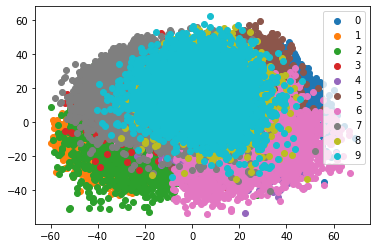

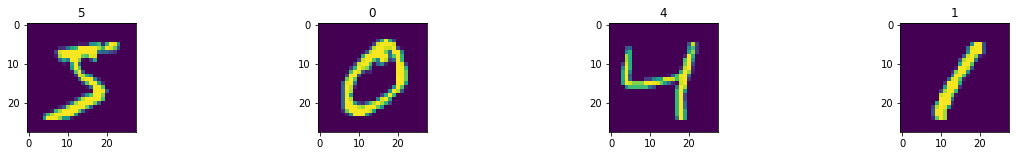

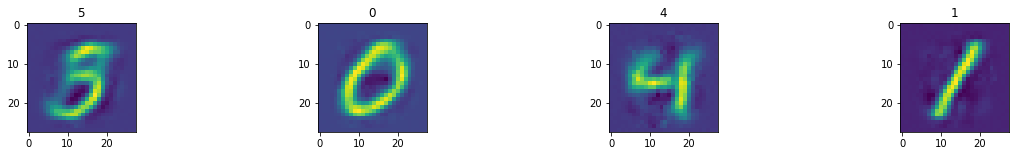

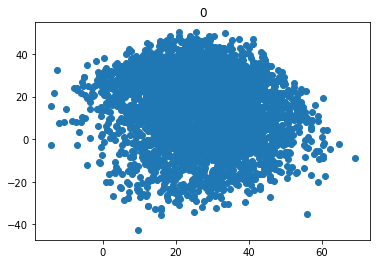

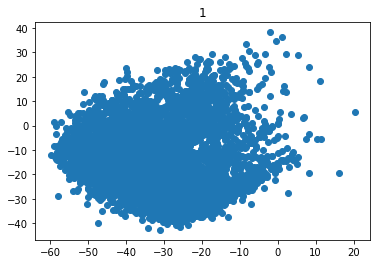

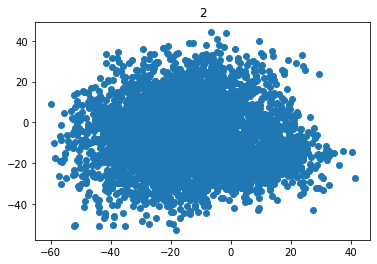

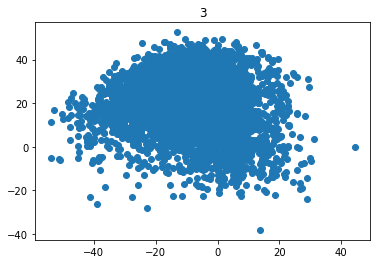

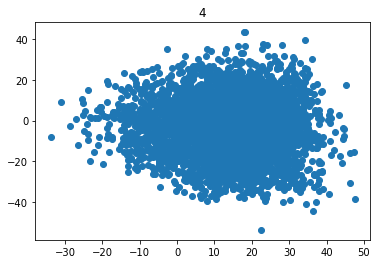

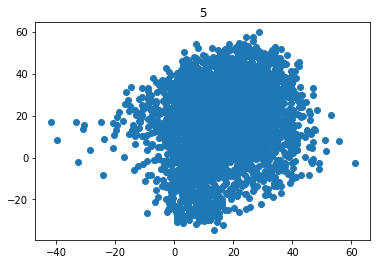

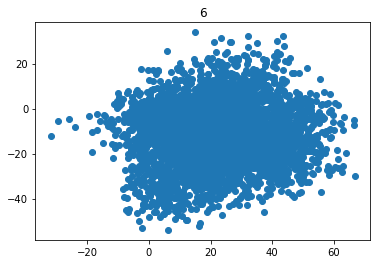

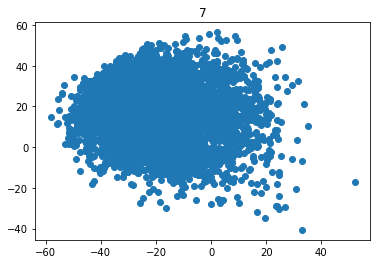

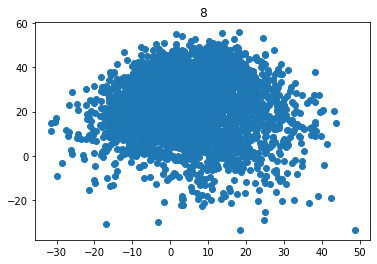

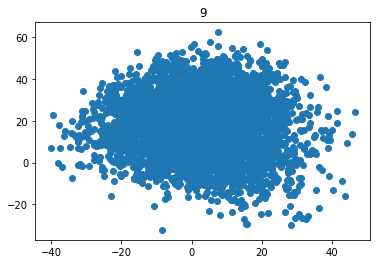

ValueError: in user code:

    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:385 call
        return self._run_internal_graph(
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_12 is incompatible with the layer: expected axis -1 of input shape to have value 8 but received input with shape [None, 2]


<Figure size 3600x144 with 0 Axes>

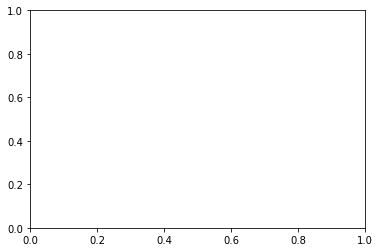

In [5]:
# Create a configuration for the dataset
config = {'loss': {'loss_type': 'mse', 'distance_metric': 'mmcd', 'mmd_weight': 1.0, 'beta': 1.0}, 
          'encoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'selu'},
                                  {'num_nodes': 64, 'activation_fn': 'relu'}]}, 
          'decoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'relu'}, 
                                  {'num_nodes': 128, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 8}, 'optimiser': {'params': {}, 'name': 'adam'}}



# Run the VAE 
vae = VAE(test_data, test_data, test_labels, config, 'vae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
vae.encode('default', epochs=500, batch_size=1000)
# get the encoded data
encoding = vae.get_encoded_data()


fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    ax.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
ax.legend()


from sklearn.preprocessing import MinMaxScaler
# Show some of the images (4)
n = 4

# Show the true data
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))
    plt.title(test_labels[i])

plt.show()
scaler = MinMaxScaler(copy=True)
test_data_scaled = scaler.fit_transform(test_data)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
encoding_mmcd = vae.encode_new_data(test_data_scaled)[0]

d = vae.decoder.predict(encoding_mmcd)
plt.figure(figsize=(20, 2))
n = 4
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[i,:].reshape(28, 28))
    plt.title(test_labels[i])
plt.show()

fig, ax = plt.subplots()
test_labels = np.array(test_labels)
cs = sns.color_palette("Set2")
for i in range(0, 10):    
    idxs = np.where(test_labels == i)
    plt.scatter(encoding[:, 0][idxs], encoding[:, 1][idxs], label=f'{i}')
    plt.title(f'{i}')
    plt.show()
ax.legend()

plt.figure(figsize=(50, 2))
fig, ax = plt.subplots()



In [17]:
print(encoding[:, 0][idxs], encoding[:, 1][idxs])

[  2.8458116 -11.445808    2.0996172 ...  -5.4951444  11.319361
  23.832443 ] [ 20.047388    2.0498147 -10.944959  ...  32.03961    32.70872
  21.226658 ]


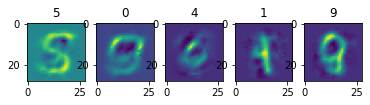

In [15]:
n = 5
mu = 0
stdev = 20
for i in range(n):
    sample_n = [[np.random.normal(mu, stdev), np.random.normal(mu, stdev), 
                 np.random.normal(mu, stdev), np.random.normal(mu, stdev), 
                 np.random.normal(mu, stdev), np.random.normal(mu, stdev), 
                 np.random.normal(mu, stdev), np.random.normal(mu, stdev)]]
    d = vae.decoder.predict(sample_n)

    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[0,:].reshape(28, 28))
    plt.title(test_labels[i])
plt.show()

In [16]:
sample_n

[[-4.927206593412932,
  20.6194887011116,
  -1.1561352670691822,
  16.779123288806517,
  25.908464036053648,
  -9.96486070942407,
  -14.706912401034202,
  -23.12734334272711]]

In [6]:
def plot_latent(decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 60.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
#     plt.xticks(pixel_range, sample_range_x)
#     plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(vae.decoder)

ValueError: in user code:

    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:385 call
        return self._run_internal_graph(
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /Users/ariane/opt/miniconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_12 is incompatible with the layer: expected axis -1 of input shape to have value 8 but received input with shape [None, 2]
